# Th analysis

In [288]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import textwrap

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple

import invisible_cities.core.fit_functions as fitf

import invisible_cities.reco.paolina_functions as plf
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.xy_algorithms as xy
import invisible_cities.reco.dst_functions as dstf

from   invisible_cities.database import load_db
from   invisible_cities.core.configure         import configure
from   invisible_cities.core.exceptions import SipmEmptyList
from   invisible_cities.core.exceptions import SipmZeroCharge

from   invisible_cities.io.pmap_io             import load_pmaps
from   invisible_cities.reco                   import pmaps_functions  as pmp
from   invisible_cities.evm.event_model        import Hit, Cluster
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps_from_file_name
from   invisible_cities.core.system_of_units_c import units

from   invisible_cities.filters.s1s2_filter    import s1s2_filter
from   invisible_cities.filters.s1s2_filter    import s2si_filter
from   invisible_cities.filters.s1s2_filter    import S12Selector

In [309]:
# code from Gonzalo
def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (1592/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*f.values[1:], *reso(f.values)))

## Reconstruction functions
This functionality will be included in the Penthesilea branch.

In [174]:
DataSiPM        = load_db.DataSiPM(0)
data_xs         = DataSiPM.X.values
data_ys         = DataSiPM.Y.values
#print(DataSiPM)
#print(data_xs)
#print(data_ys)

# histograms to be filled
l_qsipm = []            # all SiPMs
l_qsipm_cluster = []    # all SiPMs within any cluster

l_qsipm_ccenter = []    # the cluster center charges
l_qsipm_qcluster = []   # the cluster energies (same number of entries as l_qsipm_ccenter)

nccenters = 6
l_qsipm_iccenter = []
for n in range(nccenters): l_qsipm_iccenter.append([])

rqmin = 0; rqmax = 70        # charge minima and maxima for charge vs. radius plots
l_q_rlm = []; l_r_rlm = []   # for SiPM charge vs. r within lm_radius
l_q_rnlm = []; l_r_rnlm = [] # for SiPM charge vs. r within new_lm_radius

def barycenter(pos, qs):
    if not len(pos): raise SipmEmptyList
    if sum(qs) == 0: raise SipmZeroCharge
    mu  = np.average( pos           , weights=qs, axis=0)
    std = np.average((pos - mu) ** 2, weights=qs, axis=0)
    return [Cluster(sum(qs), xy(*mu), xy(*std), len(qs))]

def discard_sipms(sis, pos, qs):
    return np.delete(pos, sis, axis=0), np.delete(qs, sis)

def get_nearby_sipm_inds(cs, d, pos, qs):
    """return indices of sipms less than d from (xc,yc)"""
    return np.where(np.linalg.norm(pos - cs, axis=1) <= d)[0]

def corona(pos, qs, Qthr           =  3 * units.pes,
                    Qlm            =  35 * units.pes,
                        lm_radius  = 15.0 * units.mm,
                    new_lm_radius  = 15.0 * units.mm,
                    msipm          =  6):
    """
    corona creates a list of Clusters by
    first , identifying a loc max (gonz wanted more precise than just max sipm)
    second, calling barycenter to find the Cluster given by SiPMs around the max
    third , removing (nondestructively) the sipms contributing to that Cluster
    until there are no more local maxima
    kwargs
    Qthr : SiPMs with less than Qthr pes are ignored
    Qlm  : local maxima must have a SiPM with at least T pes
    lm_radius  : all SiPMs within lm_radius distance from the local max
           SiPM are used (by barycenter) to compute the approximate center
            of the local max.
    new_lm_radius : xs,ys,qs, of SiPMs within new_lm_radius of a local max
           are used by barycenter to compute a Cluster.
    msipm: the minimum number of SiPMs needed to make a cluster
    returns
    c    : a list of Clusters
    """
    c  = []
    # Keep SiPMs with at least Qthr pes
    above_threshold = np.where(qs >= Qthr)[0]
    pos, qs = pos[above_threshold], qs[above_threshold]
    
    if(sum(qs) < 60):
        return []
    
    # While there are more local maxima
    ncenter = 0
    while len(qs) > 0:
        hottest_sipm = np.argmax(qs)       # SiPM with largest Q
        if qs[hottest_sipm] < Qlm: break   # largest Q remaining is negligible

        # find locmax (the baryc of charge in SiPMs less than lm_radius from hottest_sipm)
        within_lm_radius = get_nearby_sipm_inds(pos[hottest_sipm], lm_radius, pos, qs)
        new_local_maximum  = barycenter(pos[within_lm_radius],
                                        qs [within_lm_radius])[0].posxy[0]

        for q,p in zip(qs,pos):
            d = np.linalg.norm(p - pos[hottest_sipm], axis=0)
            if(d < lm_radius and q > rqmin and q < rqmax):
                l_q_rlm.append(q)
                l_r_rlm.append(d)

        # new_lm_radius is an array of the responsive sipms less than
        # new_lm_radius from locmax
        within_new_lm_radius = get_nearby_sipm_inds(new_local_maximum,
                                                    new_lm_radius, pos, qs)
        for q,p in zip(qs,pos):
            d = np.linalg.norm(p - new_local_maximum, axis=0)
            #print("Types are d {0}, q {1}, new_lm_radius {2}, rqmin {3}, rqmax {4}".format(type(d),type(q),type(new_lm_radius),type(rqmin),type(rqmax)))
            if(d < new_lm_radius and q > rqmin and q < rqmax):
                l_q_rnlm.append(q)
                l_r_rnlm.append(d)

        # if there are at least msipms within_new_lm_radius, get the barycenter
        if len(within_new_lm_radius) >= msipm:
            c.extend(barycenter(pos[within_new_lm_radius],
                                qs [within_new_lm_radius]))
            for q in qs[within_new_lm_radius]: l_qsipm_cluster.append(q)
            l_qsipm_ccenter.append(qs[hottest_sipm])
            l_qsipm_qcluster.append(sum(qs))
            if(ncenter < nccenters): l_qsipm_iccenter[ncenter].append(qs[hottest_sipm])
            ncenter += 1

        # delete the SiPMs contributing to this cluster
        pos, qs = discard_sipms(within_new_lm_radius, pos, qs)

    return c

def compute_xy_position(si, slice_no):
    si      = {sipm_no: sipm[slice_no] for sipm_no, sipm in si.items()} #pmp.select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    Qs = np.array(Qs)
    #xs, ys  = data_xs[IDs], data_ys[IDs]
    for q in Qs: l_qsipm.append(q)
    pos = np.array([np.array([x,y]) for x,y in zip(data_xs[IDs],data_ys[IDs])])
    return corona(pos, Qs)

def split_energy(e, clusters):
    if len(clusters) == 1:
        return [e]
    qs = np.array([c.Q for c in clusters])
    return e * qs / np.sum(qs)

## Read the corrections table

7.92
Correction table with shape: (50, 50); bin sizes (7.9199981689453125,7.9199981689453125)


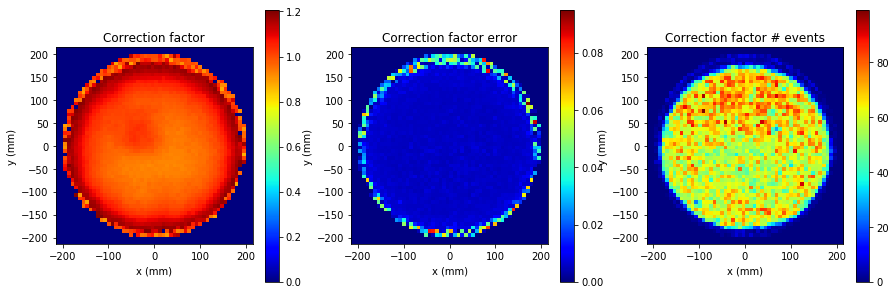

In [3]:
#corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236_b10.corr"
#corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Kr/old/mcKr.corr"
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4168/run4168_corrections.h5"
fcorr = tb.open_file(corr_file,'r')

ncbins = 54

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf = np.max(corr_fs)

fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor (MC)
ax1 = fig.add_subplot(131);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=maxf)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error (MC)
ax2 = fig.add_subplot(132)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics (MC)
ax3 = fig.add_subplot(133)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

# get the x and y bin sizes
xdiff = corr_x[1:] - corr_x[0:-1]
nz_xdiff = np.nonzero(xdiff)[0]
xbin = xdiff[nz_xdiff][0]
xcmin = np.min(corr_x)
print(xbin)

ydiff = corr_y[1:] - corr_y[0:-1]
nz_ydiff = np.nonzero(ydiff)[0]
ybin = ydiff[np.nonzero(ydiff)][0]
ycmin = np.min(corr_y)

ctbl = np.ones([len(nz_xdiff)+1,len(nz_xdiff)+1])-2
for x,y,fs in zip(corr_x,corr_y,corr_fs):
    xb = int((x-xcmin)/xbin)
    yb = int((y-ycmin)/ybin)
    ctbl[xb][yb] = fs
    #print("Filled ({0},{1}) with {2} for x = {3} and y = {4}".format(xb,yb,fs,x,y))
if(len(ctbl[ctbl < 0]) > 0):
    print("ERROR: value in correction table not filled")
print("Correction table with shape: {0}; bin sizes ({1},{2})".format(ctbl.shape,xbin,ybin))
    
def fcorr(x,y):
    xb = max(0,min(ctbl.shape[0]-1,((x-xcmin)/xbin).astype(int)))
    yb = max(0,min(ctbl.shape[1]-1,((y-ycmin)/ybin).astype(int)))

    if hasattr(xb, "__len__"):
        cf = [ctbl[xx][yy] for xx,yy in zip(xb,yb)]
        return cf
    else:
        return ctbl[xb][yb]

## Perform initial analysis with a DST

In [4]:
# code from Gonzalo
run_number    = 4484
inputfilename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4484/dst/dst_{}.root.h5".format(run_number)
full = dstf.load_dst(inputfilename, "DST", "Events")
print(len(full))
full.head()

9504


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.499970e+09,0,1,275.0,59.174740,353.042031,847550.0,55.457375,18207.923828,...,1029962.5,476,182.4125,182.4125,-58.229906,81.104390,99.843097,2.193476,45.702965,47.963936
1,3,1.499970e+09,0,1,325.0,76.771904,457.793548,732400.0,56.277750,18307.046875,...,1017012.5,452,284.6125,284.6125,15.476704,140.621437,141.470551,1.461178,50.471513,49.563160
2,5,1.499970e+09,0,1,300.0,85.588783,468.010359,865650.0,79.354250,18597.736328,...,1034887.5,597,169.2375,169.2375,-129.406866,-40.362241,135.555330,-2.839253,59.320594,49.241932
3,6,1.499970e+09,0,1,300.0,124.138268,708.545367,648700.0,73.337500,17789.914062,...,1030162.5,613,381.4625,381.4625,-77.007666,-104.085437,129.475707,-2.207770,50.810358,71.496101
4,7,1.499970e+09,0,2,275.0,77.786621,427.330454,988525.0,117.973250,17468.431641,...,1006412.5,363,17.8875,17.8875,114.734600,-118.843244,165.190027,-0.802986,42.140763,43.704905


Number of events used in histograms = 7779


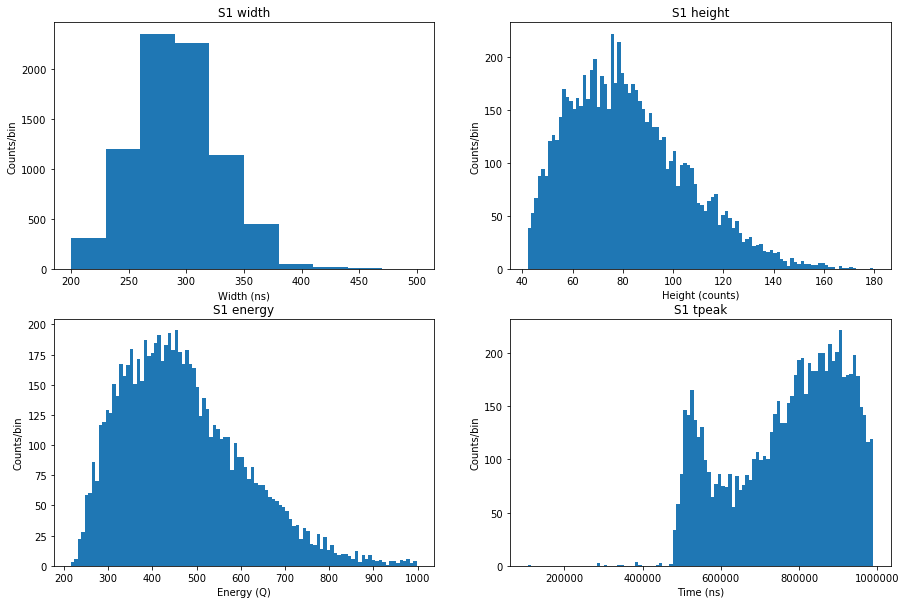

In [5]:
# histograms of quantities of interest (S1)
print("Number of events used in histograms = {0}".format(len(full[full.peak == 0])))
fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(full.S1w[full.peak == 0],bins=10)
#lnd = plt.legend(loc=1)
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.title('S1 width')
plt.xlabel('Width (ns)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(full.S1h[full.peak == 0],bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S1 height')
plt.xlabel('Height (counts)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(full.S1e[full.peak == 0],bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S1 energy')
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(full.S1t[full.peak == 0],bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S1 tpeak')
plt.xlabel('Time (ns)')
plt.ylabel('Counts/bin')

Number of events used in histograms = 9504


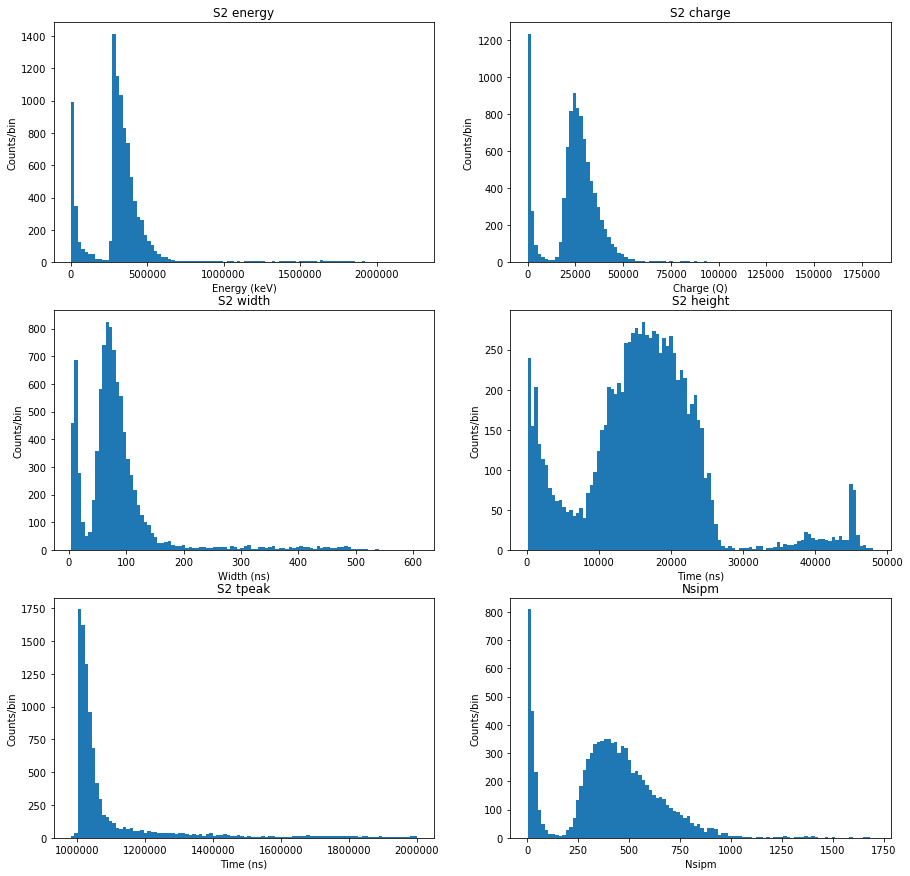

In [6]:
# histograms of quantities of interest (S2)
print("Number of events used in histograms = {0}".format(len(full)))
fig = plt.figure(1)
fig.set_figheight(15.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(321);
plt.hist(full.S2e,bins=100)
#lnd = plt.legend(loc=1)
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.title('S2 energy')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(322)
plt.hist(full.S2q,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 charge')
plt.xlabel('Charge (Q)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(323)
plt.hist(full.S2w,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 width')
plt.xlabel('Width (ns)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(324)
plt.hist(full.S2h,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 height')
plt.xlabel('Time (ns)')
plt.ylabel('Counts/bin')

ax5 = fig.add_subplot(325)
plt.hist(full.S2t,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 tpeak')
plt.xlabel('Time (ns)')
plt.ylabel('Counts/bin')

ax6 = fig.add_subplot(326)
plt.hist(full.Nsipm,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('Nsipm')
plt.xlabel('Nsipm')
plt.ylabel('Counts/bin')

In [7]:
# show energy spectrum directly from DST


## Read the PMaps and construct the hit collection for a given event
This will be performed in the future by Penthesilea.

In [8]:
# plot a 48x48 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def plot_test_event(l_X,l_Y,l_Q,l_X0,l_Y0):
    """
    Plots a SiPM map in the NEW Geometry
    """

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(20.0)
    fig.set_figwidth(20.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    plt.scatter(l_X,l_Y,c=l_Q)
    plt.colorbar()
#    for xx,yy,qq in zip(l_X,l_Y,l_Q):
#        r = Ellipse(xy=(xx, yy), width=4., height=4.);
#        r.set_facecolor('0');
#        r.set_alpha(qq);
#        ax1.add_artist(r);

    # place a large blue circle for actual EL points
    ax1.scatter(l_X0,l_Y0,marker='x',s=100,color='red')
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");

In [9]:
# Configuration information
tot_Emin = 50000; tot_Emax = 1000000
tlife = 1050
cfile = '/Users/jrenner/IFIC/IC-1/invisible_cities/config/s12_selector_4491.conf'

# read the configuration file
conf = configure(['bar', cfile])
_s1s2_selector = S12Selector(**conf.as_dict)

In [214]:
hitc_evt = []; hitc_mc = []; ext1_mc = []; ext2_mc = []
evtnum_hitc = []
#nfiles = 107
print_cut = False
tbl_ri = 0
tot_evts_sum = 0
l_rnums = [4484, 4489, 4491] # [1000]
l_nfiles = [122, 95, 107] # [1]

for rnum,nfiles in zip(l_rnums,l_nfiles):
    
    print("\n--- RUN {0} ---".format(rnum))
    for ifile in range(nfiles):

        print("File {0} of {1}...".format(ifile,nfiles))

        if(ifile < 10): fstr = "00{0}".format(ifile)
        elif(ifile < 100): fstr = "0{0}".format(ifile)
        else: fstr = "{0}".format(ifile)

        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Na/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_{0}_0_7bar_pmaps_10000.root.h5".format(ifile)
        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/{0}/pmaps/pair_1592keV_z250mm_10evt_pmaps.root.h5".format(rnum)
        filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/pmaps/pmaps.gdcsnext.{1}_{2}.root.h5".format(rnum,fstr,rnum)
        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/3913/pmaps/pmaps.gdcsnext.{0}_3913.root.h5".format(fstr)
        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/3755/pmaps/pmaps.gdcsnext.{0}_3755.root.h5".format(fstr)
        if(not os.path.isfile(filename)):
            print("File {0} does not exist. Skipping.".format(ifile))
            continue
        try:
            S1s, S2s, S2Sis = load_pmaps(filename)
        except (ValueError, tb.exceptions.NoSuchNodeError):
            print("Empty file {0}. Skipping.".format(ifile))
        event_numbers, timestamps = get_event_numbers_and_timestamps_from_file_name(filename)
        ftbl = tb.open_file(filename,'r')

        tot_evts_sum += len(event_numbers)
        print("... {0} events in file ({1} total)".format(len(event_numbers), tot_evts_sum))
        for evt_number, evt_time in zip(event_numbers,timestamps):
            #print("Processing event {0}".format(evt_number))
            hitc = []

            s1   = S1s  .get(evt_number, {})
            s2   = S2s  .get(evt_number, {})
            s2si = S2Sis.get(evt_number, {})

            if(not s1 or not s2 or not s2si):
                if(print_cut):
                    print("Skipping event {0}:".format(evt_number))
                    if(not s1): print("-- empty s1")
                    if(not s2): print("-- empty s2")
                    if(not s2si): print("-- empty s2si")
                continue
            if(len(s2.s2d) != len(s2si.s2sid)): 
                if(print_cut): print("Skipping event {0}: length of s2 does not match that of s2si".format(evt_number))
                continue
            #print(type(s2si))
            #print(s2.s2d.keys())
            #print(s2si.s2sid.keys())

            f1 = s1s2_filter(_s1s2_selector, s1, s2, s2si)
            f2 = s2si_filter(s2si)
            if not f1 or not f2:
                continue

            esum = sum([sum(earr) for pnum,(tarr,earr) in sorted(s2.s2d.items())])

            if(not (tot_Emin <= esum <= tot_Emax)):
                if(print_cut): print("Skipping event {0}: did not make energy cuts...".format(evt_number))
            else:
                t, e = next(iter(s1.s1d.values()))
                S1t  = t[np.argmax(e)]
                s2, s2si = pmp.rebin_s2si(s2,s2si,2)
                #S2, Si = rebin_s2(S2, Si)

                npeak = 0
                for peak_no, (t_peak, e_peak) in sorted(s2.s2d.items()):
                    si = s2si.s2sid[peak_no]
                    e_left = 0
                    for slice_no, (t_slice, e_slice) in enumerate(zip(t_peak, e_peak)):
                        #print("Slice number {0}".format(slice_no))
                        incomplete = False
                        for sipm_no,sipm in si.items():
                            if(slice_no >= len(sipm)):
                                incomplete = True
                        if(incomplete):
                            print("WARNING: incomplete charge information for slice ")
                            e_left += e_slice
                        else:
                            clusters = compute_xy_position(si, slice_no)
                            #print("Computed pos")
                            if(len(clusters) == 0):
                                e_left += e_slice
                            else:
                                es       = split_energy(e_slice + e_left, clusters)
                                z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0
                                for c, e in zip(clusters, es):
                                    hit       = Hit(peak_no,c,z,e)
                                    #print("hit at ({0},{1},{2};{3})".format(hit.X,hit.Y,hit.Z,hit.E))
                                    #print("hit at ({0},{1},{2};{3})".format(hit.pos[0],hit.pos[1],hit.pos[2],hit.E))
                                    hitc.append(hit)
                                e_left = 0
                    if(len(hitc) > 0 and e_left > 0):
                        hitc[-1].energy += e_left
                    npeak += 1

                hitc_evt.append(hitc)
                evtnum_hitc.append(evt_number)

                # record MC information if available
                if(ftbl.__contains__('/MC')):
                    hitcm = []
                    mctbl = ftbl.root.MC.MCTracks
                    mcevt = 0; eemax = 0
                    ext1 = np.zeros(3); ext2 = np.zeros(3)
                    #while(tbl_ri < len(mctbl) and mctbl[tbl_ri]['event_indx'] != evt_number):
                    #while(tbl_ri < len(mctbl) and (tbl_ri != 0 and mctbl[tbl_ri]['mctrk_indx'] >= mctbl[tbl_ri-1]['mctrk_indx'])):
                    #    tbl_ri += 1
                    #while(tbl_ri < len(mctbl) and mctbl[tbl_ri]['mctrk_indx'] == evt_number):
                    while(tbl_ri < len(mctbl) and (tbl_ri == 0 or mctbl[tbl_ri]['mctrk_indx'] >= mctbl[tbl_ri-1]['mctrk_indx'])):
                        hpos = mctbl[tbl_ri]['hit_position']
                        henergy = mctbl[tbl_ri]['hit_energy']
                        hit = Hit(0,Cluster(0, xy(hpos[0],hpos[1]), xy(0,0), 0),hpos[2],henergy)
                        hitcm.append(hit)
                        if(mctbl[tbl_ri]['particle_name'] == 'e+'):
                            ext1[0] = hpos[0]; ext1[1] = hpos[1]; ext1[2] = hpos[2]
                        elif(mctbl[tbl_ri]['particle_name'] == 'e-' and mctbl[tbl_ri]['energy'] > eemax):
                            ext2[0] = hpos[0]; ext2[1] = hpos[1]; ext2[2] = hpos[2]
                        print("MCTrack index = {0}".format(mctbl[tbl_ri]['mctrk_indx']))
                        tbl_ri += 1
                    hitc_mc.append(hitcm)
                    ext1_mc.append(ext1)
                    ext2_mc.append(ext2)
                    mcevt += 1
                    tbl_ri += 1

        ftbl.close()
    print("Produced hit collections for {0} events ({1} events in MC truth).".format(len(hitc_evt),len(hitc_mc)))


--- RUN 4484 ---
File 0 of 122...
... 112 events in file (112 total)
File 1 of 122...
... 1 events in file (113 total)
File 2 of 122...
... 95 events in file (208 total)
File 3 of 122...
... 112 events in file (320 total)
File 4 of 122...
... 112 events in file (432 total)
File 5 of 122...
... 100 events in file (532 total)
File 6 of 122...
... 111 events in file (643 total)
File 7 of 122...
... 112 events in file (755 total)
File 8 of 122...
... 112 events in file (867 total)
File 9 of 122...
... 112 events in file (979 total)
File 10 of 122...
... 47 events in file (1026 total)
File 11 of 122...
... 112 events in file (1138 total)
File 12 of 122...
... 75 events in file (1213 total)
File 13 of 122...
... 112 events in file (1325 total)
File 14 of 122...
... 16 events in file (1341 total)
File 15 of 122...
... 112 events in file (1453 total)
File 16 of 122...
... 112 events in file (1565 total)
File 17 of 122...
... 111 events in file (1676 total)
File 18 of 122...
... 112 events in 

File 28 of 95...
... 111 events in file (13129 total)
File 29 of 95...
... 112 events in file (13241 total)
File 30 of 95...
... 88 events in file (13329 total)
File 31 of 95...
... 110 events in file (13439 total)
File 32 of 95...
... 112 events in file (13551 total)
File 33 of 95...
... 112 events in file (13663 total)
File 34 of 95...
... 32 events in file (13695 total)
File 35 of 95...
... 84 events in file (13779 total)
File 36 of 95...
... 112 events in file (13891 total)
File 37 of 95...
Empty file 37. Skipping.
... 0 events in file (13891 total)
File 38 of 95...
... 112 events in file (14003 total)
File 39 of 95...
... 111 events in file (14114 total)
File 40 of 95...
... 79 events in file (14193 total)
File 41 of 95...
... 6 events in file (14199 total)
File 42 of 95...
... 10 events in file (14209 total)
File 43 of 95...
... 112 events in file (14321 total)
File 44 of 95...
... 112 events in file (14433 total)
File 45 of 95...
... 4 events in file (14437 total)
File 46 of 95.

... 112 events in file (24434 total)
File 83 of 107...
... 112 events in file (24546 total)
File 84 of 107...
... 112 events in file (24658 total)
File 85 of 107...
... 112 events in file (24770 total)
File 86 of 107...
... 112 events in file (24882 total)
File 87 of 107...
... 11 events in file (24893 total)
File 88 of 107...
... 74 events in file (24967 total)
File 89 of 107...
... 112 events in file (25079 total)
File 90 of 107...
... 22 events in file (25101 total)
File 91 of 107...
... 53 events in file (25154 total)
File 92 of 107...
... 112 events in file (25266 total)
File 93 of 107...
... 112 events in file (25378 total)
File 94 of 107...
... 112 events in file (25490 total)
File 95 of 107...
... 95 events in file (25585 total)
File 96 of 107...
... 95 events in file (25680 total)
File 97 of 107...
... 112 events in file (25792 total)
File 98 of 107...
... 4 events in file (25796 total)
File 99 of 107...
... 17 events in file (25813 total)
File 100 of 107...
... 112 events in 

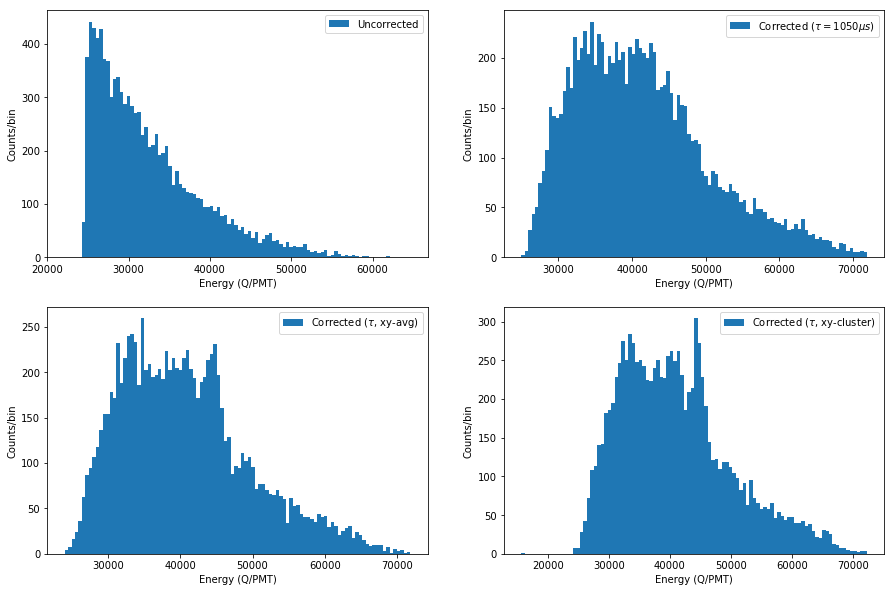

In [319]:
# energy spectrum
npmts = 11
ebins = 100
emin_hist = 150000; emax_hist = 800000
e_spec = []; emc_spec = []; r_spec = []; z_spec = []
ecorr_avg_spec = []; ecorr_tau_spec = []; ecorr_slice_spec = []
for ee in range(len(hitc_evt)):
    evt_E = sum([hh.E for hh in hitc_evt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_evt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_evt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_evt[ee]])
    if(len(hitc_evt[ee]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_Ecorrtau = evt_E/np.exp(-evt_Z/tlife)
    evt_Ecorrtau_xy = evt_Ecorrtau*fcorr(evt_X,evt_Y)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_evt[ee]])/np.exp(-evt_Z/tlife)
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Emc = 0
    if(ee < len(hitc_mc)): evt_Emc = sum([hh.E for hh in hitc_mc[ee]])
    hr = np.array([np.sqrt(hh.X**2 + hh.Y**2) < 120. for hh in hitc_evt[ee]])
    #print("E = {0}, with tau = {1}, with xy = {2}, with slices = {3}".format(evt_E,evt_Ecorrtau,evt_Ecorrtau_xy,evt_Ecorrtau_xy_slice))
    if(evt_E > emin_hist and evt_E < emax_hist and
       evt_Ecorrtau > emin_hist and evt_Ecorrtau < emax_hist and
       evt_Ecorrtau_xy > emin_hist and evt_Ecorrtau_xy < emax_hist and
       evt_Ecorrtau_xy_slice > emin_hist and evt_Ecorrtau_xy_slice < emax_hist and
       evt_R < 150.): #hr.all()):
        e_spec.append(evt_E)
        r_spec.append(evt_R)
        z_spec.append(evt_Z)
        ecorr_tau_spec.append(evt_Ecorrtau)
        ecorr_avg_spec.append(evt_Ecorrtau_xy)
        ecorr_slice_spec.append(evt_Ecorrtau_xy_slice)
    emc_spec.append(evt_Emc)

e_spec = np.array(e_spec)
ecorr_tau_spec = np.array(ecorr_tau_spec)
ecorr_avg_spec = np.array(ecorr_avg_spec)
ecorr_slice_spec = np.array(ecorr_slice_spec)

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(e_spec/npmts,bins=ebins,label='Uncorrected')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(ecorr_tau_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(ecorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-avg)'.format(tlife))
#plt.hist(ecorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$, xy-avg)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(ecorr_slice_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-cluster)'.format(tlife))
#plt.hist(ecorr_slice_spec/npmts,bins=ebins,label='Corr. ($\\tau = {0} \mu s$, xy-cluster)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

In [345]:
# create the corrected hit collection
hitc_cevt = []
for ee in range(len(hitc_evt)):
    hc_corr = []
    for hh in hitc_evt[ee]:
        hecorr = hh.E*fcorr(hh.X,hh.Y)/np.exp(-hh.Z/tlife)
        hcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
        hc_corr.append(hcorr)
    hitc_cevt.append(hc_corr)

/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


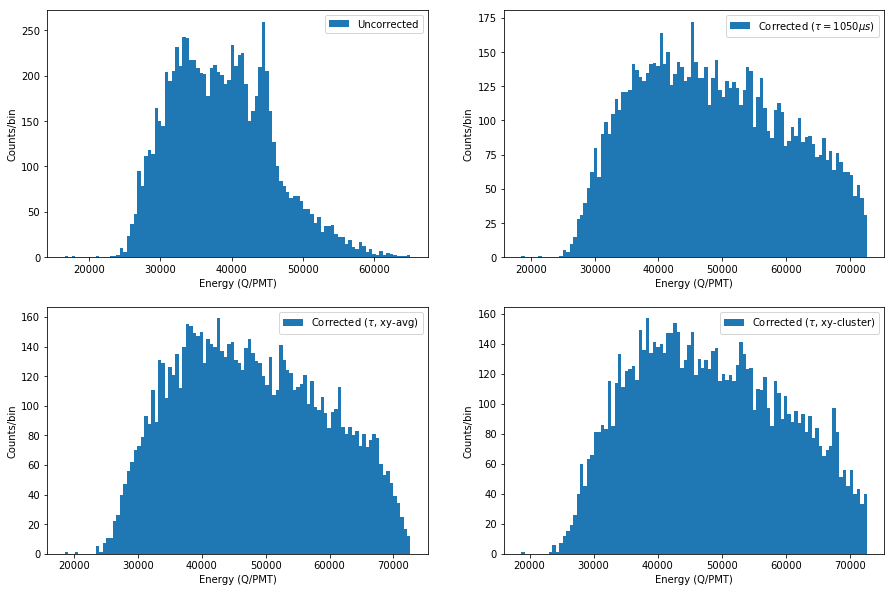

In [346]:
# energy spectrum
ec_spec = []; rc_spec = []; zc_spec = []
eccorr_avg_spec = []; eccorr_tau_spec = []; eccorr_slice_spec = []
for ee in range(len(hitc_cevt)):
    evt_E = sum([hh.E for hh in hitc_cevt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[ee]])
    if(len(hitc_cevt[ee]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_Ecorrtau = evt_E/np.exp(-evt_Z/tlife)
    evt_Ecorrtau_xy = evt_Ecorrtau*fcorr(evt_X,evt_Y)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_cevt[ee]])/np.exp(-evt_Z/tlife)
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Emc = 0
    if(evt_E > emin_hist and evt_E < emax_hist and
       evt_Ecorrtau > emin_hist and evt_Ecorrtau < emax_hist and
       evt_Ecorrtau_xy > emin_hist and evt_Ecorrtau_xy < emax_hist and
       evt_Ecorrtau_xy_slice > emin_hist and evt_Ecorrtau_xy_slice < emax_hist and
       evt_R < 150.): #hr.all()):
        ec_spec.append(evt_E)
        rc_spec.append(evt_R)
        zc_spec.append(evt_Z)
        eccorr_tau_spec.append(evt_Ecorrtau)
        eccorr_avg_spec.append(evt_Ecorrtau_xy)
        eccorr_slice_spec.append(evt_Ecorrtau_xy_slice)

ec_spec = np.array(ec_spec)
eccorr_tau_spec = np.array(eccorr_tau_spec)
eccorr_avg_spec = np.array(eccorr_avg_spec)
eccorr_slice_spec = np.array(eccorr_slice_spec)

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(ec_spec/npmts,bins=ebins,label='Uncorrected')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(eccorr_tau_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(eccorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-avg)'.format(tlife))
#plt.hist(ecorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$, xy-avg)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(eccorr_slice_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-cluster)'.format(tlife))
#plt.hist(ecorr_slice_spec/npmts,bins=ebins,label='Corr. ($\\tau = {0} \mu s$, xy-cluster)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

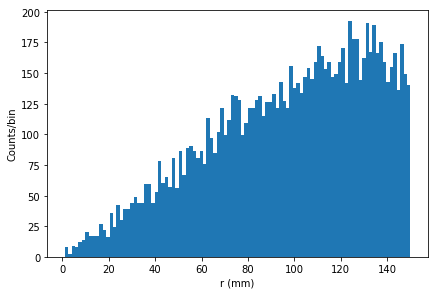

In [217]:
# look at the distribution in r
fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

# event distribution vs. R
ax1 = fig.add_subplot(221);
plt.hist(r_spec,bins=100)
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('r (mm)')
plt.ylabel('Counts/bin')

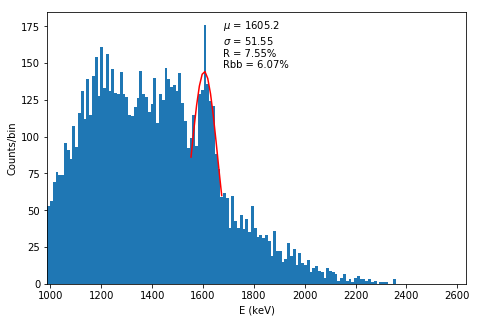

In [500]:
# closer look at the energy spectrum
CAL_FACTOR = 1600/486000
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

#y, x, _ = plt.hist(ecorr_slice_spec, 100, range=[300000,800000])
y, x, _ = plt.hist(ec_spec*CAL_FACTOR, 150, range=[300000*CAL_FACTOR,800000*CAL_FACTOR])

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 470e3*CAL_FACTOR, 510e3*CAL_FACTOR)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
plt.plot(x, f.fn(x), "r")
plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))

#plt.hist(ecorr_slice_spec,bins=200)
#plt.ylim([100000,900000])
plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')



# Paolina analysis

In [442]:
vol_min = np.array([-250, -250, -100],dtype=np.int16)  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 400],dtype=np.int16)  # volume maximum (x,y,z)
vox_size = np.array([15,15,15],dtype=np.int16)    # voxel size
blob_radius = 31.                    # blob radius in mm
ECCUT_LOW = 250000
ECCUT_HIGH = 1000000
DIST_CUT = 100.
EBLOB_CUT = 300000    # do not accept events with a single blob > this energy

In [443]:
# run Paolina for many events
trk_energies = []; 
l_eblob1 = []; l_eblob2 = []; l_eevt = []
for nevt in range(len(hitc_cevt)):
#for nevt in range(1000):
    
    hitc = hitc_cevt[nevt]
    if(len(hitc) < 2): continue
    
    # Calculate event coordinates and corrected energy.
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[nevt]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[nevt]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[nevt]])
    evt_E = sum([hh.E for hh in hitc_cevt[nevt]])
    if(len(hitc_cevt[nevt]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    
    # Make energy and radial cuts.
    if(not (evt_E > ECCUT_LOW and evt_E < ECCUT_HIGH) or evt_R >= 150.):
        continue

    print("Track {0} with {1} hits...".format(nevt,len(hitc)))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    for t in trks:
        etrk = sum([vox.E for vox in t.nodes()])
        trk_energies.append(etrk)
    itmax = np.argmax([len(t) for t in trks])
    if(len(trks[itmax])/len(voxels) < 0.95):
        continue

    eblobs = plf.blob_energies(trks[itmax],blob_radius)
    iter_eblobs = iter(eblobs)
    Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

    # ensure blob2 always has higher energy
    if(Eblob1 > Eblob2):
        eswap = Eblob1
        Eblob1 = Eblob2
        Eblob2 = eswap

    # get the extremes
    distances = plf.shortest_paths(trks[itmax])
    a,b = plf.find_extrema(distances)
    if(distances[a][b] < DIST_CUT): continue
    print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_evt),len(trks[itmax]),len(voxels),distances[a][b]))
    
    # add to the distributions if the blob energy does not exceed the upper limit
    if(Eblob1 < EBLOB_CUT and Eblob2 < EBLOB_CUT):
        l_eblob1.append(Eblob1)
        l_eblob2.append(Eblob2)
        l_eevt.append(evt_E)

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)
l_eevt = np.array(l_eevt)

Track 0 with 40 hits...
Track 3 with 50 hits...
Track 4 with 29 hits...
Track 5 with 40 hits...
Track 7 with 53 hits...
Track 8 with 55 hits...
Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 211.17287049678043
Track 9 with 50 hits...
Track 10 with 50 hits...
Found 1 tracks of 12568; max containing 25 voxels; total of 25 voxels, distance = 221.9696910486081
Track 11 with 40 hits...
Track 12 with 48 hits...
Found 1 tracks of 12568; max containing 27 voxels; total of 27 voxels, distance = 191.5055338337769
Track 13 with 23 hits...
Track 14 with 28 hits...
Track 15 with 26 hits...
Track 18 with 52 hits...
Track 19 with 24 hits...
Track 20 with 38 hits...
Track 21 with 47 hits...
Found 1 tracks of 12568; max containing 26 voxels; total of 26 voxels, distance = 139.97878108306713
Track 22 with 29 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 124.72861147858656
Track 23 with 32 hits...
Track 24 with 38 hits...
Trac

Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 125.41416208066497
Track 213 with 47 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 126.04799641418539
Track 214 with 45 hits...
Track 215 with 30 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 109.57234539366341
Track 216 with 28 hits...
Track 217 with 44 hits...
Track 218 with 35 hits...
Track 220 with 24 hits...
Track 221 with 52 hits...
Found 1 tracks of 12568; max containing 24 voxels; total of 24 voxels, distance = 162.60004856166736
Track 222 with 54 hits...
Found 1 tracks of 12568; max containing 29 voxels; total of 29 voxels, distance = 146.8649103980639
Track 223 with 41 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 117.131035185327
Track 224 with 35 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 123.14213548109737
Track 225 

Track 407 with 34 hits...
Track 408 with 48 hits...
Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 162.8410920354505
Track 409 with 33 hits...
Track 410 with 33 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 102.2439437776986
Track 411 with 32 hits...
Track 412 with 38 hits...
Track 416 with 40 hits...
Track 417 with 36 hits...
Track 418 with 28 hits...
Found 1 tracks of 12568; max containing 13 voxels; total of 13 voxels, distance = 114.98054716880789
Track 419 with 40 hits...
Track 420 with 34 hits...
Track 421 with 31 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 102.53266093146638
Track 422 with 39 hits...
Track 423 with 40 hits...
Track 424 with 38 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 124.81390849047546
Track 425 with 42 hits...
Found 1 tracks of 12568; max containing 24 voxels; total of 24 voxels, distance =

Found 1 tracks of 12568; max containing 34 voxels; total of 34 voxels, distance = 213.45160535312144
Track 610 with 45 hits...
Track 611 with 58 hits...
Track 612 with 61 hits...
Found 1 tracks of 12568; max containing 34 voxels; total of 34 voxels, distance = 302.012850976619
Track 614 with 39 hits...
Track 615 with 40 hits...
Track 616 with 44 hits...
Found 2 tracks of 12568; max containing 19 voxels; total of 20 voxels, distance = 102.06060250896702
Track 617 with 23 hits...
Track 619 with 26 hits...
Track 621 with 39 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 107.26379008625715
Track 622 with 46 hits...
Found 1 tracks of 12568; max containing 24 voxels; total of 24 voxels, distance = 111.07308024863377
Track 623 with 21 hits...
Track 624 with 68 hits...
Found 2 tracks of 12568; max containing 32 voxels; total of 33 voxels, distance = 242.99849814206326
Track 625 with 26 hits...
Track 626 with 65 hits...
Found 1 tracks of 12568; max con

Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 107.49682065153745
Track 833 with 45 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 184.31866228374116
Track 834 with 34 hits...
Track 835 with 42 hits...
Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 109.66546514478337
Track 836 with 33 hits...
Track 837 with 35 hits...
Track 838 with 33 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 101.14641803326718
Track 840 with 31 hits...
Track 841 with 23 hits...
Track 842 with 57 hits...
Track 843 with 63 hits...
Found 1 tracks of 12568; max containing 37 voxels; total of 37 voxels, distance = 177.75780014572865
Track 846 with 33 hits...
Track 847 with 32 hits...
Track 849 with 62 hits...
Found 2 tracks of 12568; max containing 34 voxels; total of 35 voxels, distance = 278.14993919402156
Track 850 with 25 hits...
Track 851 with 31 hits...
Trac

Track 1019 with 50 hits...
Track 1021 with 40 hits...
Track 1022 with 30 hits...
Track 1023 with 38 hits...
Track 1024 with 36 hits...
Track 1025 with 43 hits...
Track 1026 with 35 hits...
Track 1027 with 54 hits...
Found 1 tracks of 12568; max containing 28 voxels; total of 28 voxels, distance = 129.8300101271135
Track 1028 with 32 hits...
Found 1 tracks of 12568; max containing 12 voxels; total of 12 voxels, distance = 107.79843426893278
Track 1029 with 40 hits...
Track 1030 with 43 hits...
Track 1031 with 41 hits...
Found 2 tracks of 12568; max containing 21 voxels; total of 22 voxels, distance = 167.10035352178068
Track 1032 with 76 hits...
Track 1033 with 34 hits...
Track 1034 with 29 hits...
Track 1035 with 35 hits...
Track 1036 with 33 hits...
Track 1037 with 53 hits...
Found 2 tracks of 12568; max containing 24 voxels; total of 25 voxels, distance = 221.4267660675098
Track 1038 with 29 hits...
Track 1039 with 36 hits...
Track 1040 with 30 hits...
Track 1041 with 69 hits...
Foun

/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Track 1214 with 33 hits...
Track 1215 with 39 hits...
Track 1216 with 40 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 114.73480045623042
Track 1217 with 37 hits...
Track 1218 with 32 hits...
Track 1220 with 51 hits...
Found 1 tracks of 12568; max containing 26 voxels; total of 26 voxels, distance = 122.35293221969826
Track 1221 with 40 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 128.79523240056486
Track 1222 with 43 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 118.06840030530188
Track 1223 with 34 hits...
Track 1224 with 24 hits...
Track 1225 with 31 hits...
Track 1226 with 35 hits...
Track 1227 with 38 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 120.78796253088264
Track 1228 with 33 hits...
Track 1229 with 28 hits...
Track 1230 with 31 hits...
Track 1231 with 33 hits...
Track 1232 with 58 hits...
Found 1 t

Found 2 tracks of 12568; max containing 32 voxels; total of 33 voxels, distance = 161.9046347545168
Track 1382 with 29 hits...
Track 1385 with 47 hits...
Track 1386 with 59 hits...
Track 1387 with 35 hits...
Track 1388 with 44 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 112.56332312716839
Track 1389 with 36 hits...
Found 2 tracks of 12568; max containing 20 voxels; total of 21 voxels, distance = 102.08263365153147
Track 1390 with 55 hits...
Track 1391 with 36 hits...
Track 1392 with 37 hits...
Track 1393 with 47 hits...
Track 1394 with 39 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 143.88273265289033
Track 1396 with 28 hits...
Track 1398 with 39 hits...
Track 1399 with 35 hits...
Track 1400 with 31 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 111.38028214387774
Track 1401 with 39 hits...
Track 1402 with 40 hits...
Found 1 tracks of 12568; max containi

Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 104.00866333587055
Track 1578 with 34 hits...
Track 1579 with 35 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 141.90305219646496
Track 1580 with 47 hits...
Track 1581 with 37 hits...
Track 1582 with 57 hits...
Track 1584 with 41 hits...
Track 1586 with 37 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 120.70894197062118
Track 1587 with 48 hits...
Track 1588 with 25 hits...
Track 1591 with 29 hits...
Track 1592 with 55 hits...
Found 1 tracks of 12568; max containing 26 voxels; total of 26 voxels, distance = 208.60708948136437
Track 1594 with 41 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 191.95787721483762
Track 1596 with 46 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 142.02461778824065
Track 1597 with 21 hits...
Track 1600 with 

Track 1775 with 38 hits...
Track 1777 with 35 hits...
Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 115.38035916463735
Track 1778 with 35 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 144.50930201467378
Track 1779 with 31 hits...
Track 1780 with 60 hits...
Track 1781 with 31 hits...
Track 1783 with 26 hits...
Track 1784 with 41 hits...
Track 1785 with 51 hits...
Track 1786 with 36 hits...
Found 1 tracks of 12568; max containing 25 voxels; total of 25 voxels, distance = 159.3203083851233
Track 1787 with 43 hits...
Found 2 tracks of 12568; max containing 19 voxels; total of 20 voxels, distance = 140.5348665802727
Track 1788 with 39 hits...
Track 1789 with 35 hits...
Track 1790 with 41 hits...
Track 1792 with 34 hits...
Track 1793 with 37 hits...
Track 1794 with 54 hits...
Track 1795 with 53 hits...
Track 1797 with 50 hits...
Track 1798 with 46 hits...
Track 1800 with 43 hits...
Track 1801 with 38 hits...
Trac

Track 1961 with 33 hits...
Track 1962 with 49 hits...
Found 1 tracks of 12568; max containing 25 voxels; total of 25 voxels, distance = 165.25411570413826
Track 1964 with 38 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 105.2198425654415
Track 1965 with 38 hits...
Track 1966 with 32 hits...
Track 1967 with 34 hits...
Track 1968 with 29 hits...
Track 1969 with 26 hits...
Track 1970 with 62 hits...
Found 2 tracks of 12568; max containing 26 voxels; total of 27 voxels, distance = 114.23041659439703
Track 1971 with 51 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 179.8643355405701
Track 1972 with 40 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 139.12092804727317
Track 1973 with 37 hits...
Track 1975 with 30 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 116.15759771561528
Track 1976 with 27 hits...
Found 1 tracks of 

Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 100.0658727953334
Track 2115 with 33 hits...
Found 1 tracks of 12568; max containing 13 voxels; total of 13 voxels, distance = 103.46213277397041
Track 2116 with 28 hits...
Track 2117 with 45 hits...
Track 2119 with 66 hits...
Track 2120 with 38 hits...
Found 2 tracks of 12568; max containing 19 voxels; total of 20 voxels, distance = 108.38593553566301
Track 2121 with 36 hits...
Track 2123 with 29 hits...
Track 2124 with 61 hits...
Track 2125 with 39 hits...
Track 2126 with 40 hits...
Track 2127 with 36 hits...
Track 2128 with 34 hits...
Track 2129 with 29 hits...
Track 2132 with 50 hits...
Track 2134 with 50 hits...
Found 1 tracks of 12568; max containing 24 voxels; total of 24 voxels, distance = 135.71922710726926
Track 2135 with 17 hits...
Track 2136 with 38 hits...
Track 2137 with 41 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 136.76119199770136
Track 2140

Found 1 tracks of 12568; max containing 30 voxels; total of 30 voxels, distance = 222.37833613718487
Track 2314 with 37 hits...
Track 2315 with 44 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 156.5106136195651
Track 2316 with 47 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 156.00771668026132
Track 2317 with 47 hits...
Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 148.80784667139116
Track 2319 with 40 hits...
Track 2320 with 32 hits...
Track 2322 with 30 hits...
Track 2323 with 33 hits...
Track 2324 with 29 hits...
Track 2326 with 27 hits...
Track 2327 with 33 hits...
Track 2328 with 47 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 169.03076458164725
Track 2329 with 41 hits...
Found 2 tracks of 12568; max containing 20 voxels; total of 21 voxels, distance = 129.2250862505521
Track 2330 with 37 hits...
Found 1 tracks of 

Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 161.07073561302144
Track 2507 with 37 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 109.92090904678903
Track 2508 with 32 hits...
Track 2509 with 53 hits...
Track 2510 with 25 hits...
Track 2512 with 34 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 114.046084466998
Track 2515 with 49 hits...
Track 2516 with 46 hits...
Found 1 tracks of 12568; max containing 25 voxels; total of 25 voxels, distance = 191.39638193352897
Track 2518 with 23 hits...
Track 2519 with 42 hits...
Track 2521 with 41 hits...
Track 2522 with 49 hits...
Found 2 tracks of 12568; max containing 20 voxels; total of 21 voxels, distance = 127.0841426499494
Track 2523 with 41 hits...
Track 2524 with 41 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 155.64367990272714
Track 2525 with 37 hits...
Track 2526 with 59 

Found 1 tracks of 12568; max containing 35 voxels; total of 35 voxels, distance = 153.43428078236386
Track 2680 with 50 hits...
Track 2681 with 37 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 111.54329419594377
Track 2684 with 30 hits...
Track 2685 with 31 hits...
Track 2686 with 23 hits...
Track 2687 with 32 hits...
Track 2688 with 41 hits...
Track 2689 with 45 hits...
Track 2690 with 31 hits...
Track 2691 with 37 hits...
Track 2692 with 32 hits...
Track 2694 with 42 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 133.0360112917262
Track 2696 with 23 hits...
Track 2698 with 35 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 100.0243046245749
Track 2699 with 46 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 110.81189608162134
Track 2704 with 52 hits...
Track 2705 with 27 hits...
Track 2707 with 50 hits...
Track 2708 

Found 1 tracks of 12568; max containing 24 voxels; total of 24 voxels, distance = 117.20498613457977
Track 2867 with 39 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 149.2573956714435
Track 2868 with 47 hits...
Found 2 tracks of 12568; max containing 22 voxels; total of 23 voxels, distance = 191.35338846938777
Track 2869 with 21 hits...
Track 2870 with 36 hits...
Track 2871 with 34 hits...
Track 2872 with 50 hits...
Found 1 tracks of 12568; max containing 27 voxels; total of 27 voxels, distance = 126.06039243569755
Track 2873 with 45 hits...
Track 2874 with 57 hits...
Track 2875 with 31 hits...
Track 2876 with 38 hits...
Track 2877 with 34 hits...
Track 2879 with 44 hits...
Track 2880 with 40 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 151.8677652391701
Track 2881 with 29 hits...
Track 2882 with 50 hits...
Track 2884 with 21 hits...
Track 2885 with 30 hits...
Track 2887 with 39 hits...
Found 1 tra

Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 104.55517942586101
Track 3051 with 28 hits...
Track 3053 with 26 hits...
Track 3054 with 33 hits...
Track 3055 with 36 hits...
Track 3056 with 27 hits...
Track 3058 with 35 hits...
Track 3059 with 37 hits...
Track 3060 with 40 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 170.97593233310124
Track 3061 with 32 hits...
Track 3062 with 50 hits...
Found 1 tracks of 12568; max containing 24 voxels; total of 24 voxels, distance = 175.41040097752943
Track 3063 with 30 hits...
Track 3065 with 38 hits...
Track 3066 with 42 hits...
Track 3067 with 50 hits...
Found 2 tracks of 12568; max containing 28 voxels; total of 29 voxels, distance = 157.96609074357417
Track 3069 with 38 hits...
Track 3070 with 31 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 127.47180136917055
Track 3071 with 32 hits...
Track 3074 with 41 hits...
Track 307

Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 106.1539619291865
Track 3253 with 43 hits...
Track 3254 with 34 hits...
Track 3255 with 54 hits...
Found 1 tracks of 12568; max containing 32 voxels; total of 32 voxels, distance = 141.38959175988077
Track 3256 with 27 hits...
Track 3257 with 45 hits...
Track 3258 with 41 hits...
Track 3259 with 32 hits...
Track 3260 with 36 hits...
Track 3261 with 34 hits...
Track 3263 with 52 hits...
Found 1 tracks of 12568; max containing 29 voxels; total of 29 voxels, distance = 123.1495955088961
Track 3265 with 34 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 126.43027765416471
Track 3266 with 57 hits...
Found 2 tracks of 12568; max containing 24 voxels; total of 25 voxels, distance = 149.22813404579682
Track 3267 with 39 hits...
Track 3269 with 29 hits...
Track 3270 with 40 hits...
Track 3271 with 49 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 vo

Track 3425 with 41 hits...
Track 3426 with 38 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 105.66766111241415
Track 3427 with 48 hits...
Track 3428 with 56 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 195.3170776211877
Track 3429 with 30 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 143.2581921007462
Track 3430 with 27 hits...
Track 3431 with 42 hits...
Track 3433 with 30 hits...
Track 3435 with 33 hits...
Found 1 tracks of 12568; max containing 12 voxels; total of 12 voxels, distance = 110.47621320704198
Track 3436 with 72 hits...
Track 3437 with 55 hits...
Track 3438 with 33 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 118.62092962273911
Track 3439 with 34 hits...
Track 3441 with 52 hits...
Found 2 tracks of 12568; max containing 23 voxels; total of 24 voxels, distance = 120.29286720476111
Track 3442 with 58

Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 132.88918121199018
Track 3608 with 64 hits...
Track 3609 with 40 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 105.74725192896629
Track 3610 with 42 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 161.35741698646282
Track 3611 with 30 hits...
Track 3612 with 31 hits...
Track 3614 with 35 hits...
Track 3616 with 44 hits...
Track 3617 with 39 hits...
Track 3618 with 44 hits...
Track 3619 with 56 hits...
Track 3620 with 30 hits...
Track 3621 with 48 hits...
Found 1 tracks of 12568; max containing 25 voxels; total of 25 voxels, distance = 189.9478199831607
Track 3622 with 34 hits...
Track 3623 with 40 hits...
Track 3624 with 37 hits...
Track 3625 with 33 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 130.6807993293176
Track 3626 with 45 hits...
Found 1 tracks of 12568; max containin

Found 1 tracks of 12568; max containing 24 voxels; total of 24 voxels, distance = 176.75652895470526
Track 3779 with 57 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 183.80959817368776
Track 3780 with 51 hits...
Found 2 tracks of 12568; max containing 27 voxels; total of 28 voxels, distance = 156.97956412794377
Track 3781 with 45 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 130.81403996779375
Track 3784 with 48 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 126.08839467932759
Track 3785 with 34 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 182.6472475097835
Track 3787 with 36 hits...
Track 3789 with 33 hits...
Track 3791 with 35 hits...
Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 126.33472018131195
Track 3793 with 47 hits...
Found 1 tracks of 12568; max containing 19 voxels; 

Found 1 tracks of 12568; max containing 28 voxels; total of 28 voxels, distance = 196.10070397176779
Track 3962 with 38 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 221.39598280315212
Track 3963 with 38 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 122.55205855729555
Track 3966 with 33 hits...
Track 3967 with 30 hits...
Track 3968 with 34 hits...
Track 3970 with 19 hits...
Track 3971 with 30 hits...
Track 3974 with 33 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 107.14034500205844
Track 3975 with 35 hits...
Track 3976 with 32 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 155.39147324041502
Track 3977 with 54 hits...
Track 3978 with 74 hits...
Found 1 tracks of 12568; max containing 32 voxels; total of 32 voxels, distance = 173.86345606480268
Track 3979 with 37 hits...
Track 3980 with 42 hits...
Track 3981 with 

Track 4184 with 28 hits...
Track 4185 with 24 hits...
Track 4186 with 32 hits...
Track 4187 with 28 hits...
Track 4188 with 36 hits...
Track 4189 with 58 hits...
Found 1 tracks of 12568; max containing 31 voxels; total of 31 voxels, distance = 145.5427896992762
Track 4190 with 42 hits...
Track 4191 with 25 hits...
Track 4192 with 48 hits...
Track 4194 with 54 hits...
Track 4195 with 39 hits...
Track 4196 with 30 hits...
Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 130.4430421026205
Track 4198 with 40 hits...
Track 4199 with 25 hits...
Track 4202 with 50 hits...
Track 4203 with 30 hits...
Track 4204 with 38 hits...
Track 4206 with 30 hits...
Track 4208 with 44 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 155.11751554470453
Track 4209 with 21 hits...
Track 4210 with 68 hits...
Found 2 tracks of 12568; max containing 32 voxels; total of 33 voxels, distance = 152.8703275241914
Track 4211 with 36 hits...
Track

Track 4373 with 30 hits...
Track 4376 with 22 hits...
Track 4377 with 37 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 127.19099183383724
Track 4378 with 20 hits...
Track 4379 with 33 hits...
Track 4380 with 53 hits...
Track 4381 with 39 hits...
Found 2 tracks of 12568; max containing 21 voxels; total of 22 voxels, distance = 151.0217202948284
Track 4382 with 33 hits...
Track 4383 with 53 hits...
Track 4384 with 57 hits...
Track 4385 with 36 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 167.27677086259857
Track 4386 with 37 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 109.24548388389782
Track 4388 with 30 hits...
Track 4390 with 44 hits...
Track 4393 with 63 hits...
Track 4394 with 29 hits...
Track 4395 with 40 hits...
Track 4396 with 38 hits...
Track 4397 with 34 hits...
Track 4398 with 40 hits...
Found 1 tracks of 12568; max containing 18 voxels; total 

Track 4580 with 40 hits...
Track 4581 with 21 hits...
Track 4583 with 35 hits...
Track 4584 with 50 hits...
Found 1 tracks of 12568; max containing 26 voxels; total of 26 voxels, distance = 125.55613164446143
Track 4585 with 38 hits...
Track 4586 with 41 hits...
Track 4587 with 32 hits...
Track 4588 with 22 hits...
Track 4591 with 51 hits...
Found 1 tracks of 12568; max containing 27 voxels; total of 27 voxels, distance = 169.94394804086897
Track 4593 with 44 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 121.14434920810206
Track 4594 with 38 hits...
Found 2 tracks of 12568; max containing 21 voxels; total of 22 voxels, distance = 113.86743501554524
Track 4595 with 25 hits...
Found 1 tracks of 12568; max containing 13 voxels; total of 13 voxels, distance = 102.64368591450759
Track 4597 with 42 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 118.93968203540659
Track 4598 with 56 hits...
Found 2 tracks o

Track 4766 with 33 hits...
Track 4767 with 44 hits...
Track 4768 with 46 hits...
Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 121.46054658156376
Track 4769 with 68 hits...
Track 4770 with 27 hits...
Track 4771 with 34 hits...
Track 4772 with 30 hits...
Track 4773 with 39 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 122.54366024132518
Track 4774 with 51 hits...
Track 4776 with 34 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 107.86055578509891
Track 4778 with 50 hits...
Track 4780 with 38 hits...
Track 4781 with 39 hits...
Track 4782 with 52 hits...
Track 4783 with 25 hits...
Track 4784 with 53 hits...
Found 2 tracks of 12568; max containing 29 voxels; total of 30 voxels, distance = 291.042763394056
Track 4785 with 54 hits...
Track 4786 with 43 hits...
Found 2 tracks of 12568; max containing 24 voxels; total of 25 voxels, distance = 133.32298530784408
Track 4787 

Found 1 tracks of 12568; max containing 29 voxels; total of 29 voxels, distance = 200.46941683909694
Track 4922 with 38 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 162.85822544751142
Track 4923 with 32 hits...
Track 4924 with 32 hits...
Track 4926 with 40 hits...
Track 4927 with 52 hits...
Track 4928 with 44 hits...
Track 4929 with 33 hits...
Track 4930 with 48 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 131.1149964778701
Track 4932 with 42 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 115.32026501316058
Track 4933 with 34 hits...
Track 4935 with 37 hits...
Track 4936 with 43 hits...
Track 4937 with 58 hits...
Track 4940 with 53 hits...
Track 4941 with 29 hits...
Track 4942 with 44 hits...
Track 4943 with 14 hits...
Track 4944 with 47 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 109.27979839933546
Track 4946

Track 5121 with 34 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 138.00348708597124
Track 5123 with 41 hits...
Track 5124 with 43 hits...
Track 5125 with 34 hits...
Track 5127 with 52 hits...
Found 1 tracks of 12568; max containing 24 voxels; total of 24 voxels, distance = 119.32664622357215
Track 5128 with 40 hits...
Track 5129 with 29 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 110.72817411199358
Track 5130 with 33 hits...
Track 5131 with 46 hits...
Track 5133 with 63 hits...
Track 5135 with 51 hits...
Found 1 tracks of 12568; max containing 27 voxels; total of 27 voxels, distance = 132.68367873634693
Track 5136 with 33 hits...
Track 5137 with 39 hits...
Track 5139 with 35 hits...
Track 5140 with 41 hits...
Track 5143 with 39 hits...
Track 5144 with 41 hits...
Track 5145 with 34 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 145.42215541712312
Track 514

Track 5319 with 39 hits...
Track 5320 with 31 hits...
Track 5322 with 37 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 108.56571819241984
Track 5323 with 33 hits...
Track 5324 with 37 hits...
Track 5325 with 32 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 100.58240753553336
Track 5327 with 27 hits...
Track 5328 with 41 hits...
Track 5329 with 37 hits...
Track 5330 with 34 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 169.81450672038068
Track 5331 with 33 hits...
Track 5332 with 30 hits...
Track 5333 with 36 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 114.6550946438238
Track 5334 with 31 hits...
Track 5335 with 28 hits...
Track 5336 with 25 hits...
Track 5337 with 35 hits...
Track 5338 with 27 hits...
Track 5339 with 40 hits...
Track 5342 with 27 hits...
Track 5343 with 25 hits...
Track 5344 with 50 hits...
Fou

Track 5515 with 36 hits...
Track 5517 with 21 hits...
Track 5518 with 53 hits...
Track 5519 with 43 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 140.14824838726528
Track 5521 with 40 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 139.28033110229626
Track 5522 with 31 hits...
Track 5523 with 42 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 158.0953914837725
Track 5525 with 38 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 168.90810539441182
Track 5526 with 32 hits...
Track 5527 with 36 hits...
Track 5528 with 60 hits...
Track 5529 with 22 hits...
Track 5530 with 47 hits...
Found 1 tracks of 12568; max containing 28 voxels; total of 28 voxels, distance = 110.18680605999734
Track 5532 with 44 hits...
Track 5534 with 38 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 186.24331

Track 5699 with 34 hits...
Track 5700 with 30 hits...
Track 5701 with 61 hits...
Found 2 tracks of 12568; max containing 34 voxels; total of 35 voxels, distance = 137.94796328947365
Track 5703 with 51 hits...
Track 5704 with 25 hits...
Track 5705 with 27 hits...
Track 5706 with 27 hits...
Track 5707 with 28 hits...
Track 5708 with 20 hits...
Track 5709 with 53 hits...
Found 2 tracks of 12568; max containing 21 voxels; total of 22 voxels, distance = 204.19662419352272
Track 5710 with 41 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 162.47939814991824
Track 5711 with 46 hits...
Track 5712 with 34 hits...
Track 5713 with 32 hits...
Track 5714 with 44 hits...
Track 5716 with 33 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 101.0414593547365
Track 5717 with 23 hits...
Track 5718 with 29 hits...
Track 5719 with 48 hits...
Found 1 tracks of 12568; max containing 26 voxels; total of 26 voxels, distance = 14

Track 5875 with 40 hits...
Track 5876 with 42 hits...
Track 5877 with 35 hits...
Track 5878 with 52 hits...
Track 5879 with 35 hits...
Track 5880 with 28 hits...
Found 1 tracks of 12568; max containing 13 voxels; total of 13 voxels, distance = 109.92167391245913
Track 5883 with 23 hits...
Track 5884 with 32 hits...
Track 5885 with 17 hits...
Track 5886 with 47 hits...
Track 5887 with 21 hits...
Track 5889 with 31 hits...
Track 5891 with 32 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 107.84172272078015
Track 5892 with 80 hits...
Track 5893 with 26 hits...
Track 5894 with 41 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 105.55064320685048
Track 5895 with 49 hits...
Track 5896 with 29 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 146.13886781447758
Track 5897 with 34 hits...
Track 5899 with 45 hits...
Track 5900 with 38 hits...
Found 1 tracks of 12568; max 

Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 227.05245403155095
Track 6054 with 44 hits...
Track 6055 with 28 hits...
Track 6056 with 30 hits...
Track 6057 with 32 hits...
Track 6058 with 32 hits...
Track 6060 with 40 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 102.68164166859071
Track 6061 with 62 hits...
Found 1 tracks of 12568; max containing 30 voxels; total of 30 voxels, distance = 171.99396770454103
Track 6062 with 39 hits...
Track 6064 with 67 hits...
Found 1 tracks of 12568; max containing 29 voxels; total of 29 voxels, distance = 289.75010119781285
Track 6065 with 37 hits...
Track 6066 with 26 hits...
Track 6067 with 44 hits...
Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 221.10942828775808
Track 6068 with 32 hits...
Track 6069 with 58 hits...
Track 6070 with 54 hits...
Track 6071 with 29 hits...
Track 6073 with 39 hits...
Track 6074 with 24 hits...
Track 607

Track 6271 with 49 hits...
Track 6272 with 40 hits...
Track 6274 with 48 hits...
Track 6275 with 49 hits...
Found 1 tracks of 12568; max containing 27 voxels; total of 27 voxels, distance = 240.739374128171
Track 6276 with 45 hits...
Track 6277 with 36 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 149.8643526229544
Track 6278 with 44 hits...
Track 6279 with 30 hits...
Track 6280 with 31 hits...
Track 6281 with 26 hits...
Found 1 tracks of 12568; max containing 12 voxels; total of 12 voxels, distance = 124.3718065661279
Track 6282 with 29 hits...
Track 6283 with 48 hits...
Track 6284 with 43 hits...
Track 6285 with 39 hits...
Track 6286 with 34 hits...
Track 6287 with 72 hits...
Found 1 tracks of 12568; max containing 40 voxels; total of 40 voxels, distance = 200.14102404058494
Track 6288 with 44 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 170.23044659337089
Track 6289 with 44 hits...
Found 1 track

Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 134.90667519761013
Track 6429 with 61 hits...
Found 1 tracks of 12568; max containing 34 voxels; total of 34 voxels, distance = 219.20611338773693
Track 6430 with 35 hits...
Track 6431 with 31 hits...
Track 6432 with 29 hits...
Track 6434 with 36 hits...
Track 6437 with 35 hits...
Track 6438 with 34 hits...
Track 6439 with 42 hits...
Found 1 tracks of 12568; max containing 25 voxels; total of 25 voxels, distance = 148.76835014954835
Track 6440 with 46 hits...
Track 6441 with 39 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 145.2261696086076
Track 6442 with 28 hits...
Found 1 tracks of 12568; max containing 13 voxels; total of 13 voxels, distance = 114.94372273460539
Track 6443 with 32 hits...
Found 1 tracks of 12568; max containing 13 voxels; total of 13 voxels, distance = 118.94327602279881
Track 6444 with 36 hits...
Track 6445 with 42 hits...
Track 6446 with 6

Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 163.63571362546836
Track 6639 with 37 hits...
Track 6640 with 29 hits...
Track 6641 with 29 hits...
Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 128.9078845441084
Track 6643 with 27 hits...
Track 6644 with 42 hits...
Track 6645 with 28 hits...
Track 6647 with 37 hits...
Track 6648 with 40 hits...
Track 6649 with 49 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 135.6697346092541
Track 6650 with 39 hits...
Track 6651 with 53 hits...
Track 6652 with 39 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 145.66309388094382
Track 6653 with 41 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 130.19082819745336
Track 6655 with 39 hits...
Track 6656 with 35 hits...
Track 6657 with 34 hits...
Track 6659 with 44 hits...
Track 6660 with 34 hits...
Track 6661 

Track 6828 with 33 hits...
Track 6829 with 66 hits...
Track 6831 with 53 hits...
Found 2 tracks of 12568; max containing 24 voxels; total of 25 voxels, distance = 266.7991047373267
Track 6832 with 51 hits...
Found 2 tracks of 12568; max containing 24 voxels; total of 25 voxels, distance = 192.15873820479982
Track 6833 with 51 hits...
Track 6834 with 32 hits...
Track 6837 with 48 hits...
Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 185.94974252061797
Track 6838 with 56 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 169.8111594628503
Track 6839 with 39 hits...
Track 6841 with 30 hits...
Track 6842 with 46 hits...
Track 6843 with 26 hits...
Track 6844 with 33 hits...
Track 6845 with 43 hits...
Track 6847 with 34 hits...
Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 167.41413369914812
Track 6848 with 39 hits...
Track 6849 with 51 hits...
Found 2 tracks of 12568; max containin

Track 7018 with 37 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 111.36160435504534
Track 7020 with 29 hits...
Track 7021 with 34 hits...
Track 7022 with 27 hits...
Track 7023 with 30 hits...
Track 7024 with 47 hits...
Track 7026 with 37 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 122.05390847840256
Track 7028 with 36 hits...
Track 7029 with 33 hits...
Track 7030 with 19 hits...
Track 7031 with 25 hits...
Track 7032 with 31 hits...
Track 7033 with 22 hits...
Track 7036 with 31 hits...
Track 7037 with 27 hits...
Track 7038 with 28 hits...
Track 7040 with 45 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 108.28964366572147
Track 7041 with 38 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 101.44254186626313
Track 7044 with 27 hits...
Track 7045 with 33 hits...
Track 7046 with 34 hits...
Track 7047 with 29 hits...
Fo

Track 7231 with 29 hits...
Track 7232 with 35 hits...
Track 7233 with 28 hits...
Track 7234 with 22 hits...
Track 7237 with 41 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 226.93037293599446
Track 7239 with 35 hits...
Track 7241 with 39 hits...
Track 7242 with 37 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 143.92995621883338
Track 7244 with 40 hits...
Track 7245 with 46 hits...
Track 7247 with 60 hits...
Found 1 tracks of 12568; max containing 27 voxels; total of 27 voxels, distance = 203.83511191004823
Track 7248 with 39 hits...
Track 7249 with 38 hits...
Track 7250 with 63 hits...
Track 7253 with 27 hits...
Track 7254 with 39 hits...
Track 7255 with 41 hits...
Track 7256 with 30 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 148.66927874858112
Track 7257 with 46 hits...
Track 7258 with 33 hits...
Track 7261 with 44 hits...
Track 7262 with 33 hits...
Tr

Track 7422 with 29 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 111.20936710047602
Track 7423 with 34 hits...
Track 7425 with 26 hits...
Track 7426 with 39 hits...
Track 7427 with 37 hits...
Track 7428 with 34 hits...
Track 7429 with 50 hits...
Track 7430 with 28 hits...
Track 7431 with 27 hits...
Track 7432 with 38 hits...
Track 7433 with 43 hits...
Track 7434 with 31 hits...
Track 7435 with 23 hits...
Track 7436 with 30 hits...
Track 7437 with 40 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 131.88012380668303
Track 7438 with 41 hits...
Track 7439 with 31 hits...
Track 7440 with 54 hits...
Track 7441 with 31 hits...
Track 7442 with 43 hits...
Track 7443 with 29 hits...
Track 7444 with 35 hits...
Track 7445 with 38 hits...
Track 7446 with 45 hits...
Track 7447 with 44 hits...
Track 7449 with 40 hits...
Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 129.0315639286

Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 115.42596102231235
Track 7616 with 43 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 162.39351604971785
Track 7617 with 40 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 105.52565976583716
Track 7619 with 34 hits...
Track 7620 with 36 hits...
Track 7621 with 43 hits...
Track 7622 with 40 hits...
Track 7623 with 45 hits...
Track 7624 with 34 hits...
Track 7626 with 33 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 147.198476480014
Track 7627 with 42 hits...
Track 7628 with 35 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 113.92640723403893
Track 7629 with 32 hits...
Track 7630 with 34 hits...
Track 7632 with 28 hits...
Track 7633 with 44 hits...
Track 7636 with 66 hits...
Found 1 tracks of 12568; max containing 35 voxels; total of 35 vo

Found 1 tracks of 12568; max containing 28 voxels; total of 28 voxels, distance = 186.22738388148105
Track 7813 with 45 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 180.23871389392787
Track 7814 with 24 hits...
Track 7815 with 31 hits...
Track 7816 with 37 hits...
Track 7818 with 38 hits...
Track 7819 with 38 hits...
Track 7820 with 34 hits...
Track 7821 with 31 hits...
Track 7822 with 35 hits...
Track 7823 with 36 hits...
Track 7824 with 32 hits...
Track 7825 with 37 hits...
Track 7828 with 37 hits...
Track 7829 with 42 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 118.08639920171684
Track 7830 with 44 hits...
Found 1 tracks of 12568; max containing 25 voxels; total of 25 voxels, distance = 122.1486699843706
Track 7831 with 32 hits...
Track 7832 with 28 hits...
Track 7833 with 22 hits...
Track 7834 with 28 hits...
Track 7835 with 41 hits...
Found 1 tracks of 12568; max containing 20 voxels; total 

Found 2 tracks of 12568; max containing 26 voxels; total of 27 voxels, distance = 193.8971739012185
Track 8030 with 30 hits...
Track 8031 with 36 hits...
Track 8033 with 23 hits...
Track 8034 with 41 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 210.7997828266516
Track 8035 with 26 hits...
Track 8036 with 45 hits...
Found 2 tracks of 12568; max containing 27 voxels; total of 28 voxels, distance = 156.41136975386695
Track 8037 with 27 hits...
Track 8039 with 28 hits...
Track 8040 with 32 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 103.34345842455399
Track 8041 with 31 hits...
Track 8043 with 38 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 134.24338020359232
Track 8044 with 26 hits...
Track 8045 with 32 hits...
Track 8046 with 24 hits...
Track 8047 with 33 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 151.630361

Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 143.31333049783103
Track 8232 with 25 hits...
Track 8233 with 54 hits...
Track 8234 with 42 hits...
Track 8236 with 35 hits...
Track 8237 with 29 hits...
Track 8238 with 38 hits...
Track 8239 with 38 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 116.89678446093815
Track 8241 with 32 hits...
Track 8242 with 48 hits...
Track 8243 with 32 hits...
Track 8244 with 28 hits...
Track 8246 with 38 hits...
Track 8247 with 26 hits...
Track 8249 with 30 hits...
Track 8250 with 59 hits...
Track 8251 with 62 hits...
Found 1 tracks of 12568; max containing 32 voxels; total of 32 voxels, distance = 289.3199306657918
Track 8252 with 31 hits...
Track 8253 with 43 hits...
Track 8254 with 36 hits...
Track 8255 with 29 hits...
Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 140.37914748470513
Track 8256 with 46 hits...
Track 8257 with 35 hits...
Fou

Track 8439 with 37 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 132.3107166304546
Track 8440 with 61 hits...
Found 2 tracks of 12568; max containing 27 voxels; total of 28 voxels, distance = 130.43140129898822
Track 8441 with 37 hits...
Track 8442 with 27 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 120.49617527909055
Track 8443 with 24 hits...
Track 8444 with 47 hits...
Track 8445 with 48 hits...
Found 1 tracks of 12568; max containing 30 voxels; total of 30 voxels, distance = 126.63465310933346
Track 8446 with 32 hits...
Track 8447 with 15 hits...
Track 8448 with 44 hits...
Track 8449 with 34 hits...
Track 8450 with 64 hits...
Track 8451 with 59 hits...
Track 8454 with 37 hits...
Track 8456 with 33 hits...
Track 8457 with 63 hits...
Found 2 tracks of 12568; max containing 32 voxels; total of 33 voxels, distance = 196.84940828947893
Track 8459 with 40 hits...
Found 1 tracks of 12568; max containi

Track 8620 with 28 hits...
Track 8621 with 31 hits...
Track 8622 with 20 hits...
Track 8623 with 36 hits...
Track 8624 with 36 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 122.3063628435041
Track 8625 with 29 hits...
Track 8626 with 28 hits...
Track 8628 with 40 hits...
Track 8629 with 44 hits...
Track 8630 with 40 hits...
Track 8631 with 34 hits...
Track 8632 with 36 hits...
Track 8633 with 31 hits...
Track 8634 with 37 hits...
Track 8635 with 41 hits...
Track 8638 with 33 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 106.58808081609233
Track 8639 with 19 hits...
Track 8640 with 30 hits...
Track 8641 with 66 hits...
Found 1 tracks of 12568; max containing 33 voxels; total of 33 voxels, distance = 237.81112456908568
Track 8642 with 39 hits...
Track 8643 with 35 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 156.72175417856863
Track 8644 with 46 hits...
Fou

Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 128.66162973405764
Track 8826 with 38 hits...
Track 8827 with 23 hits...
Track 8828 with 46 hits...
Track 8830 with 33 hits...
Track 8831 with 55 hits...
Track 8832 with 53 hits...
Track 8833 with 34 hits...
Track 8834 with 37 hits...
Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 106.98159919686076
Track 8835 with 38 hits...
Track 8836 with 40 hits...
Track 8837 with 34 hits...
Track 8838 with 36 hits...
Track 8839 with 39 hits...
Track 8840 with 32 hits...
Track 8841 with 54 hits...
Track 8842 with 32 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 137.9093513671123
Track 8843 with 48 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 114.8077995098132
Track 8844 with 39 hits...
Track 8845 with 30 hits...
Found 1 tracks of 12568; max containing 13 voxels; total of 13 voxels, distance = 111

Track 9006 with 26 hits...
Track 9008 with 57 hits...
Track 9011 with 38 hits...
Track 9012 with 31 hits...
Track 9013 with 35 hits...
Track 9014 with 37 hits...
Track 9015 with 34 hits...
Track 9016 with 33 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 106.75874032128088
Track 9017 with 35 hits...
Track 9019 with 52 hits...
Track 9021 with 40 hits...
Track 9022 with 37 hits...
Track 9023 with 38 hits...
Track 9024 with 45 hits...
Track 9027 with 40 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 147.80363613406357
Track 9028 with 31 hits...
Track 9029 with 35 hits...
Track 9030 with 46 hits...
Track 9031 with 37 hits...
Track 9035 with 39 hits...
Track 9036 with 45 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 178.47875138208428
Track 9037 with 55 hits...
Track 9038 with 36 hits...
Track 9040 with 38 hits...
Found 1 tracks of 12568; max containing 18 voxels

Track 9210 with 33 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 121.79882172351019
Track 9211 with 33 hits...
Track 9212 with 43 hits...
Track 9213 with 38 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 134.84480066837165
Track 9214 with 29 hits...
Track 9216 with 29 hits...
Track 9217 with 44 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 103.18901454678237
Track 9218 with 34 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 102.48995909103091
Track 9220 with 42 hits...
Track 9221 with 47 hits...
Track 9222 with 47 hits...
Found 2 tracks of 12568; max containing 28 voxels; total of 29 voxels, distance = 152.01142554318207
Track 9223 with 41 hits...
Track 9224 with 49 hits...
Found 2 tracks of 12568; max containing 21 voxels; total of 22 voxels, distance = 100.46218152453525
Track 9225 with 26 hits...
Track 9226 with 

Track 9396 with 29 hits...
Track 9397 with 34 hits...
Track 9398 with 35 hits...
Track 9399 with 31 hits...
Track 9400 with 45 hits...
Track 9401 with 26 hits...
Track 9402 with 26 hits...
Track 9403 with 28 hits...
Track 9404 with 33 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 157.68629855162342
Track 9405 with 35 hits...
Track 9408 with 39 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 107.103051587984
Track 9409 with 28 hits...
Track 9410 with 31 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 109.7794826390406
Track 9411 with 22 hits...
Track 9412 with 26 hits...
Track 9413 with 30 hits...
Track 9414 with 30 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 118.35109566855785
Track 9415 with 51 hits...
Found 1 tracks of 12568; max containing 27 voxels; total of 27 voxels, distance = 211.67872121330902
Track 9416 w

Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 110.64395863595901
Track 9593 with 36 hits...
Track 9594 with 32 hits...
Track 9595 with 25 hits...
Track 9597 with 55 hits...
Track 9598 with 33 hits...
Track 9599 with 33 hits...
Track 9600 with 26 hits...
Track 9602 with 29 hits...
Track 9604 with 34 hits...
Track 9608 with 21 hits...
Track 9609 with 52 hits...
Track 9610 with 32 hits...
Track 9612 with 41 hits...
Track 9613 with 53 hits...
Found 1 tracks of 12568; max containing 24 voxels; total of 24 voxels, distance = 273.76501213320483
Track 9614 with 20 hits...
Track 9615 with 41 hits...
Found 2 tracks of 12568; max containing 20 voxels; total of 21 voxels, distance = 162.6288276672632
Track 9616 with 57 hits...
Found 2 tracks of 12568; max containing 33 voxels; total of 34 voxels, distance = 151.97705216175143
Track 9617 with 33 hits...
Track 9618 with 38 hits...
Track 9619 with 33 hits...
Track 9620 with 43 hits...
Track 9621 with 30 hits...
Tra

Found 1 tracks of 12568; max containing 29 voxels; total of 29 voxels, distance = 129.9784525353009
Track 9773 with 31 hits...
Track 9774 with 42 hits...
Track 9776 with 21 hits...
Track 9777 with 33 hits...
Track 9778 with 33 hits...
Track 9779 with 34 hits...
Track 9780 with 26 hits...
Track 9781 with 28 hits...
Track 9782 with 37 hits...
Track 9784 with 33 hits...
Track 9785 with 33 hits...
Track 9786 with 50 hits...
Track 9787 with 26 hits...
Track 9788 with 33 hits...
Track 9789 with 27 hits...
Track 9790 with 30 hits...
Track 9791 with 33 hits...
Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 119.51853169684904
Track 9792 with 44 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 138.42465151925083
Track 9793 with 46 hits...
Track 9794 with 40 hits...
Track 9795 with 34 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 109.32269590885058
Track 9796 with 34 hits...
Tra

Found 1 tracks of 12568; max containing 29 voxels; total of 29 voxels, distance = 100.98833510509772
Track 9963 with 32 hits...
Track 9964 with 35 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 111.7392366642399
Track 9966 with 36 hits...
Track 9967 with 42 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 128.61310090497685
Track 9968 with 32 hits...
Track 9970 with 36 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 240.6293237386449
Track 9971 with 51 hits...
Track 9972 with 34 hits...
Track 9974 with 33 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 106.45716371426846
Track 9975 with 37 hits...
Track 9976 with 29 hits...
Track 9977 with 31 hits...
Track 9978 with 19 hits...
Track 9979 with 31 hits...
Track 9980 with 39 hits...
Track 9981 with 32 hits...
Track 9982 with 34 hits...
Found 1 tracks of 12568; max containin

Track 10159 with 46 hits...
Track 10160 with 41 hits...
Track 10161 with 32 hits...
Track 10162 with 40 hits...
Track 10163 with 31 hits...
Track 10164 with 33 hits...
Track 10165 with 35 hits...
Track 10166 with 25 hits...
Found 1 tracks of 12568; max containing 10 voxels; total of 10 voxels, distance = 107.10332299641289
Track 10169 with 43 hits...
Track 10170 with 53 hits...
Track 10171 with 37 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 126.0575512895422
Track 10172 with 30 hits...
Track 10173 with 33 hits...
Track 10174 with 40 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 175.51330436564277
Track 10175 with 24 hits...
Track 10176 with 28 hits...
Track 10177 with 39 hits...
Track 10178 with 26 hits...
Track 10179 with 36 hits...
Track 10180 with 46 hits...
Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 166.86615187237533
Track 10181 with 47 hits...
Track 101

Found 1 tracks of 12568; max containing 26 voxels; total of 26 voxels, distance = 159.13323363479142
Track 10369 with 59 hits...
Track 10370 with 38 hits...
Track 10371 with 34 hits...
Track 10372 with 40 hits...
Track 10373 with 34 hits...
Track 10374 with 46 hits...
Track 10376 with 34 hits...
Track 10377 with 35 hits...
Track 10378 with 27 hits...
Track 10379 with 47 hits...
Found 1 tracks of 12568; max containing 25 voxels; total of 25 voxels, distance = 163.01541319973927
Track 10380 with 36 hits...
Track 10381 with 34 hits...
Track 10383 with 44 hits...
Track 10384 with 29 hits...
Track 10385 with 44 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 169.5777377954248
Track 10386 with 30 hits...
Track 10388 with 25 hits...
Track 10389 with 42 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 100.09625121827848
Track 10390 with 34 hits...
Track 10391 with 21 hits...
Found 1 tracks of 12568; max containi

Track 10567 with 41 hits...
Track 10568 with 29 hits...
Track 10569 with 34 hits...
Track 10570 with 39 hits...
Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 128.71579849221106
Track 10571 with 35 hits...
Track 10572 with 23 hits...
Found 1 tracks of 12568; max containing 12 voxels; total of 12 voxels, distance = 104.28545091669093
Track 10573 with 35 hits...
Track 10575 with 30 hits...
Track 10576 with 42 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 138.13585961222032
Track 10577 with 42 hits...
Found 1 tracks of 12568; max containing 28 voxels; total of 28 voxels, distance = 116.01804473462636
Track 10579 with 29 hits...
Found 1 tracks of 12568; max containing 13 voxels; total of 13 voxels, distance = 114.7995076303913
Track 10581 with 24 hits...
Track 10582 with 40 hits...
Track 10583 with 49 hits...
Track 10584 with 22 hits...
Track 10585 with 37 hits...
Track 10586 with 41 hits...
Track 10587 with 48 

Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 141.1866123731467
Track 10740 with 48 hits...
Track 10741 with 51 hits...
Track 10742 with 43 hits...
Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 111.96823505907939
Track 10743 with 39 hits...
Track 10744 with 24 hits...
Track 10745 with 30 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 135.79986287958644
Track 10746 with 56 hits...
Found 1 tracks of 12568; max containing 30 voxels; total of 30 voxels, distance = 268.27179750996174
Track 10747 with 77 hits...
Track 10748 with 26 hits...
Track 10749 with 25 hits...
Track 10750 with 9 hits...
Track 10752 with 29 hits...
Track 10753 with 29 hits...
Track 10755 with 27 hits...
Track 10756 with 33 hits...
Track 10758 with 37 hits...
Track 10759 with 35 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 112.5876147904491
Track 10760 with 27 hi

Track 10941 with 37 hits...
Track 10943 with 31 hits...
Track 10944 with 48 hits...
Track 10945 with 42 hits...
Track 10946 with 30 hits...
Track 10947 with 34 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 119.6151043922211
Track 10948 with 32 hits...
Track 10949 with 58 hits...
Track 10950 with 35 hits...
Track 10951 with 22 hits...
Track 10952 with 38 hits...
Track 10955 with 33 hits...
Track 10956 with 32 hits...
Track 10957 with 34 hits...
Track 10959 with 56 hits...
Track 10960 with 36 hits...
Track 10961 with 36 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 128.48336897150426
Track 10962 with 38 hits...
Track 10963 with 32 hits...
Track 10964 with 49 hits...
Found 1 tracks of 12568; max containing 23 voxels; total of 23 voxels, distance = 243.55395806560722
Track 10965 with 31 hits...
Track 10966 with 72 hits...
Track 10968 with 35 hits...
Track 10969 with 34 hits...
Found 1 tracks of 12568; m

Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 126.98997130111746
Track 11122 with 74 hits...
Found 1 tracks of 12568; max containing 45 voxels; total of 45 voxels, distance = 190.1241075131266
Track 11123 with 40 hits...
Track 11124 with 31 hits...
Track 11125 with 44 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 145.52687908354073
Track 11126 with 34 hits...
Track 11128 with 34 hits...
Found 1 tracks of 12568; max containing 20 voxels; total of 20 voxels, distance = 105.52189479861534
Track 11129 with 31 hits...
Track 11130 with 41 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 118.47162084908067
Track 11131 with 26 hits...
Found 1 tracks of 12568; max containing 12 voxels; total of 12 voxels, distance = 105.13892308911198
Track 11132 with 43 hits...
Found 2 tracks of 12568; max containing 21 voxels; total of 22 voxels, distance = 229.8772129962267
Track 11133 wit

Found 1 tracks of 12568; max containing 25 voxels; total of 25 voxels, distance = 115.75501570086597
Track 11312 with 30 hits...
Track 11315 with 32 hits...
Track 11316 with 53 hits...
Found 1 tracks of 12568; max containing 29 voxels; total of 29 voxels, distance = 204.731748137451
Track 11317 with 29 hits...
Track 11318 with 55 hits...
Found 1 tracks of 12568; max containing 27 voxels; total of 27 voxels, distance = 145.39789248570543
Track 11319 with 40 hits...
Track 11320 with 44 hits...
Track 11321 with 35 hits...
Track 11323 with 39 hits...
Track 11324 with 61 hits...
Track 11325 with 24 hits...
Track 11326 with 46 hits...
Track 11327 with 39 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 148.8582782269438
Track 11328 with 29 hits...
Track 11329 with 41 hits...
Track 11330 with 36 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 199.18011915209
Track 11331 with 24 hits...
Track 11332 with 33 hits.

Found 1 tracks of 12568; max containing 28 voxels; total of 28 voxels, distance = 114.80461514662363
Track 11517 with 29 hits...
Track 11518 with 31 hits...
Track 11519 with 33 hits...
Track 11520 with 21 hits...
Track 11521 with 73 hits...
Track 11523 with 45 hits...
Track 11524 with 37 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 188.85946102403238
Track 11525 with 31 hits...
Track 11526 with 28 hits...
Track 11527 with 44 hits...
Track 11528 with 23 hits...
Track 11529 with 42 hits...
Track 11531 with 31 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 116.12257333373451
Track 11533 with 38 hits...
Track 11534 with 47 hits...
Found 1 tracks of 12568; max containing 17 voxels; total of 17 voxels, distance = 140.28421441580016
Track 11536 with 25 hits...
Track 11537 with 49 hits...
Track 11538 with 39 hits...
Track 11539 with 51 hits...
Found 2 tracks of 12568; max containing 23 voxels; total of 24 v

Found 1 tracks of 12568; max containing 27 voxels; total of 27 voxels, distance = 102.48327004305042
Track 11700 with 38 hits...
Track 11701 with 33 hits...
Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 127.39948292337304
Track 11702 with 54 hits...
Found 1 tracks of 12568; max containing 26 voxels; total of 26 voxels, distance = 117.16243090732026
Track 11703 with 40 hits...
Track 11704 with 45 hits...
Track 11705 with 41 hits...
Track 11706 with 43 hits...
Track 11708 with 33 hits...
Track 11711 with 35 hits...
Track 11712 with 40 hits...
Track 11713 with 59 hits...
Found 1 tracks of 12568; max containing 30 voxels; total of 30 voxels, distance = 208.40977041528822
Track 11714 with 45 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 120.08878411064175
Track 11715 with 36 hits...
Track 11716 with 41 hits...
Track 11717 with 27 hits...
Track 11718 with 59 hits...
Found 1 tracks of 12568; max containing 27 voxe

Found 2 tracks of 12568; max containing 20 voxels; total of 21 voxels, distance = 128.20050014555483
Track 11874 with 33 hits...
Track 11875 with 34 hits...
Track 11877 with 29 hits...
Track 11878 with 34 hits...
Found 1 tracks of 12568; max containing 16 voxels; total of 16 voxels, distance = 103.5676575751013
Track 11879 with 32 hits...
Track 11880 with 36 hits...
Track 11881 with 24 hits...
Track 11883 with 51 hits...
Track 11884 with 31 hits...
Track 11885 with 33 hits...
Track 11886 with 28 hits...
Track 11887 with 29 hits...
Track 11889 with 46 hits...
Track 11890 with 58 hits...
Found 1 tracks of 12568; max containing 26 voxels; total of 26 voxels, distance = 106.50176012537732
Track 11891 with 31 hits...
Track 11892 with 36 hits...
Track 11894 with 44 hits...
Track 11895 with 33 hits...
Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 128.40952170788108
Track 11896 with 45 hits...
Found 2 tracks of 12568; max containing 21 voxels; total of 22 vo

Track 12055 with 37 hits...
Track 12056 with 30 hits...
Found 1 tracks of 12568; max containing 14 voxels; total of 14 voxels, distance = 100.59685064762576
Track 12057 with 47 hits...
Track 12058 with 30 hits...
Track 12059 with 69 hits...
Found 2 tracks of 12568; max containing 28 voxels; total of 29 voxels, distance = 263.3473179562133
Track 12060 with 47 hits...
Track 12061 with 42 hits...
Found 1 tracks of 12568; max containing 15 voxels; total of 15 voxels, distance = 135.98026374213615
Track 12062 with 39 hits...
Track 12063 with 52 hits...
Track 12064 with 34 hits...
Track 12065 with 60 hits...
Track 12067 with 65 hits...
Track 12068 with 41 hits...
Track 12069 with 32 hits...
Track 12070 with 36 hits...
Track 12071 with 38 hits...
Track 12072 with 46 hits...
Found 1 tracks of 12568; max containing 22 voxels; total of 22 voxels, distance = 124.53848862417591
Track 12073 with 34 hits...
Track 12074 with 47 hits...
Track 12075 with 33 hits...
Track 12076 with 33 hits...
Track 120

Track 12240 with 28 hits...
Found 1 tracks of 12568; max containing 13 voxels; total of 13 voxels, distance = 102.64113519641595
Track 12242 with 55 hits...
Found 1 tracks of 12568; max containing 28 voxels; total of 28 voxels, distance = 100.94276521742516
Track 12243 with 56 hits...
Track 12244 with 49 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 162.03707218699097
Track 12247 with 30 hits...
Track 12248 with 45 hits...
Track 12249 with 73 hits...
Track 12250 with 22 hits...
Track 12251 with 31 hits...
Track 12252 with 35 hits...
Track 12253 with 39 hits...
Found 2 tracks of 12568; max containing 21 voxels; total of 22 voxels, distance = 168.76047032754713
Track 12254 with 33 hits...
Track 12255 with 26 hits...
Track 12256 with 35 hits...
Found 1 tracks of 12568; max containing 21 voxels; total of 21 voxels, distance = 165.03187955101856
Track 12257 with 35 hits...
Track 12258 with 30 hits...
Track 12259 with 25 hits...
Track 12260 with 46

Found 1 tracks of 12568; max containing 18 voxels; total of 18 voxels, distance = 134.4679067944623
Track 12425 with 40 hits...
Found 1 tracks of 12568; max containing 19 voxels; total of 19 voxels, distance = 106.40691026697345
Track 12426 with 34 hits...
Track 12427 with 44 hits...
Track 12428 with 35 hits...
Track 12429 with 36 hits...
Track 12430 with 26 hits...
Track 12431 with 36 hits...
Track 12432 with 42 hits...
Track 12433 with 62 hits...
Found 2 tracks of 12568; max containing 28 voxels; total of 29 voxels, distance = 276.62798308751735
Track 12434 with 29 hits...
Track 12435 with 54 hits...
Track 12436 with 54 hits...
Found 1 tracks of 12568; max containing 29 voxels; total of 29 voxels, distance = 128.3032874891865
Track 12437 with 23 hits...
Track 12439 with 42 hits...
Track 12440 with 47 hits...
Found 2 tracks of 12568; max containing 22 voxels; total of 23 voxels, distance = 174.518042787211
Track 12441 with 41 hits...
Found 1 tracks of 12568; max containing 24 voxels; 

Number of events I1 (1053.4979423868313 keV, 1218.1069958847736 keV): 480
Number of events I2 (1524.6090534979423 keV, 1679.0123456790122 keV): 480
Number of events I3 (1700.7407407407406 keV, 2995.884773662551 keV): 480


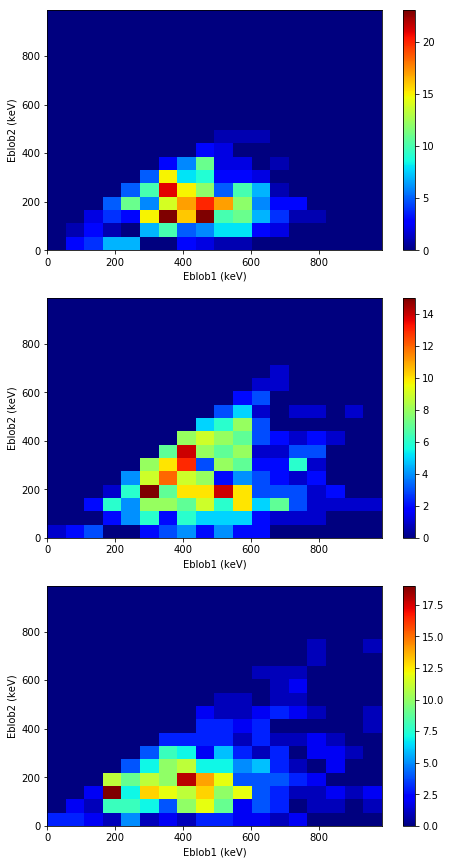

In [502]:
# Plot Eblob1 vs. Eblob2 in several intervals
nbins_blobs = 18

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(7.5);

# define intervals
eb1_low = 320000; eb1_high = 370000
eb2_low = 463100; eb2_high = 510000
eb3_low = 516600; eb3_high = 910000

# axes
ax_low = 15000; ax_high = 285000

# cuts
cuts_1 = ((l_eevt > eb1_low) & (l_eevt < eb1_high))
cuts_2 = ((l_eevt > eb2_low) & (l_eevt < eb2_high))
cuts_3 = ((l_eevt > eb3_low) & (l_eevt < eb3_high))

print("Number of events I1 ({0} keV, {1} keV): {2}".format(eb1_low*CAL_FACTOR,eb1_high*CAL_FACTOR,len(l_eblob1[cuts_1])))
print("Number of events I2 ({0} keV, {1} keV): {2}".format(eb2_low*CAL_FACTOR,eb2_high*CAL_FACTOR,len(l_eblob1[cuts_2])))
print("Number of events I3 ({0} keV, {1} keV): {2}".format(eb3_low*CAL_FACTOR,eb3_high*CAL_FACTOR,len(l_eblob1[cuts_3])))

# interval 1
ax1 = fig.add_subplot(311);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_1]*CAL_FACTOR, l_eblob2[cuts_1]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,300000*CAL_FACTOR],[0,300000*CAL_FACTOR]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("Eblob1 (keV)")
ax1.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp1)

# interval 2
ax2 = fig.add_subplot(312);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_2]*CAL_FACTOR, l_eblob2[cuts_2]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,300000*CAL_FACTOR],[0,300000*CAL_FACTOR]])
extent2 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp2 = ax2.imshow(hxy, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("Eblob1 (keV)")
ax2.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp2)

# interval 3
ax3 = fig.add_subplot(313);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_3]*CAL_FACTOR, l_eblob2[cuts_3]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,300000*CAL_FACTOR],[0,300000*CAL_FACTOR]])
extent3 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp3 = ax3.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("Eblob1 (keV)")
ax3.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp3)

Number of events: 481


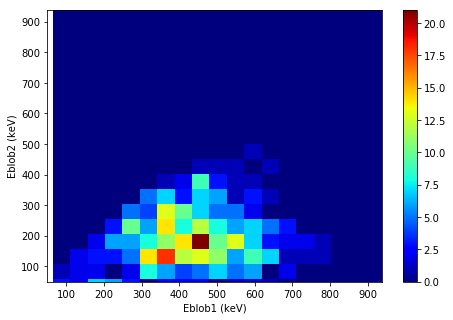

In [438]:
# Plot Eblob1 vs. Eblob2
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

Ecut_low_blobs = 0
Ecut_high_blobs = 301000

xcut_low = 15000
xcut_high = 285000

#cuts_blob = ((dist_cuts) & (l_dblobs > trklen_low))
#((l_etotcorr > Ecut_low) & (l_etotcorr < Ecut_high) & 
#             (l_eblob1 > Ecut_low_blobs) & (l_eblob2 < Ecut_high_blobs) & 
#             (l_dblobs > trklen_low))
cuts_blob = (l_eblob1 > Ecut_low_blobs) & (l_eblob2 < Ecut_high_blobs)
#print(l_hcindex[np.nonzero(cuts_blob & (l_eblob1 > 500))])
print("Number of events: {0}".format(len(l_eblob1[cuts_blob])))

# create the x-y projection
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_blob]*CAL_FACTOR, l_eblob2[cuts_blob]*CAL_FACTOR, normed=False, bins=(20, 20))
#hxy, xxy, yxy = np.histogram2d(l_eblob1, l_eblob2, normed=False, bins=(20, 20))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
#extent2 = [0, 200000, 0, 200000]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
plt.xlabel("Eblob1 (keV)")
plt.ylabel("Eblob2 (keV)")
plt.xlim([xcut_low*CAL_FACTOR,xcut_high*CAL_FACTOR])
plt.ylim([xcut_low*CAL_FACTOR,xcut_high*CAL_FACTOR])
#plt.xlim([Ecut_low_blobs,max(l_eblob2[cuts_blob])])
#plt.ylim([Ecut_low_blobs,max(l_eblob1[cuts_blob])])
plt.colorbar()

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(e_spec[l_eblob1 < 20000],bins=30,label='Single-track')
plt.hist(e_spec[l_eblob1 > 20000],bins=40,alpha=0.5,label='Double-track')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

Running Paolina for event 30 (event number 55) with blob radius 25.0
Event 30 with total energy 446592.163312912
Found 2 tracks; max containing 27 voxels; total of 29 voxels
Extreme0 at (51.47520882222102,0.07835242722592284,39.258058035714285) with energy 56273.31330002002
Extreme1 at (102.0502027524932,25.732451110597175,118.11600446428571) with energy 139246.6159103431


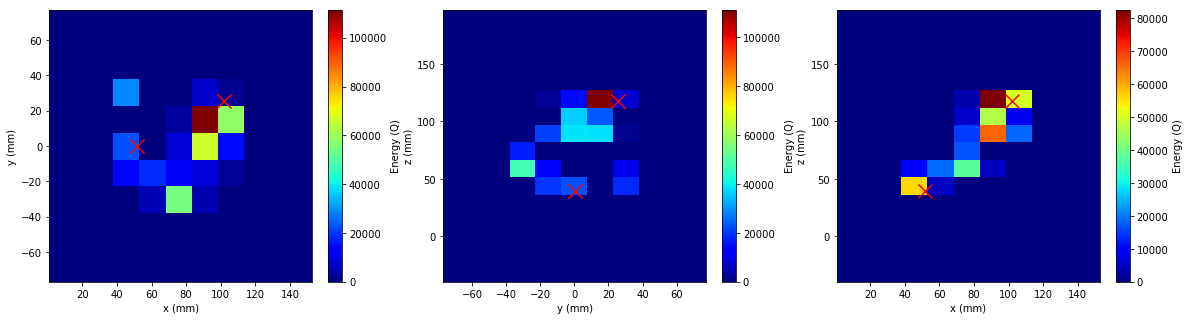

In [201]:
nevt = 30
hitc = hitc_evt[nevt]
print("Running Paolina for event {0} (event number {1}) with blob radius {2}".format(nevt,evtnum_hitc[nevt],blob_radius))

evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(nevt,evt_E))

voxels = plf.voxelize_hits(hitc,vox_size)
trks = plf.make_track_graphs(voxels,vox_size)
for t in trks:
    etrk = sum([vox.E for vox in t.nodes()])
    trk_energies.append(etrk)
itmax = np.argmax([len(t) for t in trks])
print("Found {0} tracks; max containing {1} voxels; total of {2} voxels".format(len(trks),len(trks[itmax]),len(voxels)))

eblobs = plf.blob_energies(trks[itmax],blob_radius)
iter_eblobs = iter(eblobs)
if(len(eblobs) > 1):
    Eblob1, Eblob2 = next(iter_eblobs), next(iter_eblobs)
else:
    Eblob1 = Eblob2 = next(iter_eblobs)

# get the extremes
distances = plf.shortest_paths(trks[itmax])
exts = plf.find_extrema(distances)
iter_exts = iter(exts)
if(len(exts) > 1):
    a,b = next(iter_exts),next(iter_exts)
else:
    a = b = next(iter_exts)
    
# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
#for vv in trks[itmax]:
for vv in voxels:
    varr_x.append(vv.pos[0])
    varr_y.append(vv.pos[1])
    varr_z.append(vv.pos[2])
    varr_c.append(vv.E)
    
vtrk_max = 1.0*np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = 1.0*np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])
vtrk_len = np.abs(vtrk_max-vtrk_min)
vtrk_max = vtrk_max + 1.0*vtrk_len
vtrk_min = vtrk_min - 1.0*vtrk_len

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_xlim([vtrk_min[0],vtrk_max[0]])
ax1.set_ylim([vtrk_min[1],vtrk_max[1]])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (Q)')
ax1.scatter(a.pos[0],a.pos[1],marker='x',s=200,color='red')
ax1.scatter(b.pos[0],b.pos[1],marker='x',s=200,color='red')

# Create the y-z projection.
ax2 = fig.add_subplot(132)
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_xlim([vtrk_min[1],vtrk_max[1]])
ax2.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp2 = plt.colorbar(sp2)
cbp2.set_label('Energy (Q)')
ax2.scatter(a.pos[1],a.pos[2],marker='x',s=200,color='red')
ax2.scatter(b.pos[1],b.pos[2],marker='x',s=200,color='red')

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
ax3.set_xlim([vtrk_min[0],vtrk_max[0]])
ax3.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (Q)');
ax3.scatter(a.pos[0],a.pos[2],marker='x',s=200,color='red')
ax3.scatter(b.pos[0],b.pos[2],marker='x',s=200,color='red')

print("Extreme0 at ({0},{1},{2}) with energy {3}".format(a.pos[0],a.pos[1],a.pos[2],Eblob1))
print("Extreme1 at ({0},{1},{2}) with energy {3}".format(b.pos[0],b.pos[1],b.pos[2],Eblob2))

0


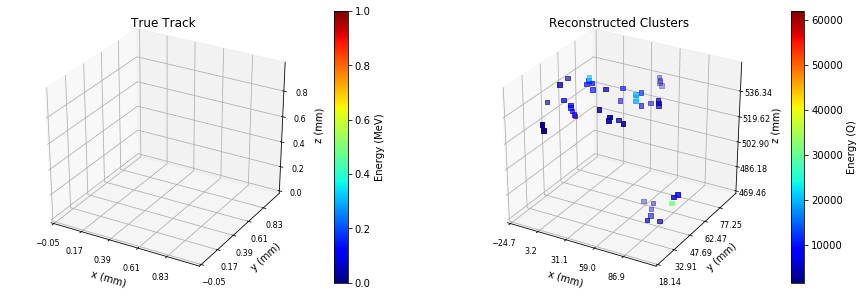

In [158]:
# plot the clusters in 3D
carr_x = []; carr_y = []; carr_z = []; carr_c = []
for cc in hitc:
    if(cc.E > 1):
        carr_x.append(cc.X)
        carr_y.append(cc.Y)
        carr_z.append(cc.Z)
        carr_c.append(cc.E)

mcarr_x = []; mcarr_y = []; mcarr_z = []; mcarr_c = []
if(nevt < len(hitc_mc)):
    hitcm = hitc_mc[nevt]
    for cc in hitcm:
        mcarr_x.append(cc.X)
        mcarr_y.append(cc.Y)
        mcarr_z.append(cc.Z)
        mcarr_c.append(cc.E)

print(sum(mcarr_c))
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# true track
ax1 = fig.add_subplot(121, projection='3d')
sc3d = ax1.scatter(mcarr_x,mcarr_y,mcarr_z,marker='s',cmap='jet',c=mcarr_c)
xst, xen = ax1.get_xlim(); ax1.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax1.get_ylim(); ax1.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax1.get_zlim(); ax1.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_zlabel("z (mm)")
ax1.set_title("True Track")
lb_x = ax1.get_xticklabels()
lb_y = ax1.get_yticklabels()
lb_z = ax1.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (MeV)')

# reconstructed clusters
ax2 = fig.add_subplot(122, projection='3d')
sc3d = ax2.scatter(carr_x,carr_y,carr_z,marker='s',cmap='jet',c=carr_c)
xst, xen = ax2.get_xlim(); ax2.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax2.get_ylim(); ax2.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax2.get_zlim(); ax2.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")
ax2.set_zlabel("z (mm)")
ax2.set_title("Reconstructed Clusters")
lb_x = ax2.get_xticklabels()
lb_y = ax2.get_yticklabels()
lb_z = ax2.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (Q)')

# Paolina track
#ax3 = fig.add_subplot(133, projection='3d')
#sc3d = ax3.scatter(varr_x,varr_y,varr_z,marker='s',cmap='jet',c=varr_c)
#xst, xen = ax3.get_xlim(); ax3.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
#yst, yen = ax3.get_ylim(); ax3.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
#zst, zen = ax3.get_zlim(); ax3.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
#ax3.set_xlabel("x (mm)")
#ax3.set_ylabel("y (mm)")
#ax3.set_zlabel("z (mm)")
#ax3.set_title("Paolina Track")
#lb_x = ax3.get_xticklabels()
#lb_y = ax3.get_yticklabels()
#lb_z = ax3.get_zticklabels()
#for lb in (lb_x + lb_y + lb_z):
#    lb.set_fontsize(8.)
#cbp1 = plt.colorbar(sc3d)
#cbp1.set_label('Energy (Q)')

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(trk_energies,bins=200)
ax1.set_title("Paolina track energies")
ax1.set_xlabel("Energy (Q)")
ax1.set_ylabel("Counts/bin")
ax1.set_xlim([0,10000])
#ax2.set_yscale("log")

nn = 0
for ee,te in zip(evtnum_hitc,trk_energies):
    if(400 < te < 20000):
        print("Event {0} (number {1})".format(nn,ee))
    nn += 1

## Histograms from the Corona step

In [ ]:
# total charge
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

# charge histogram
#ax1 = fig.add_subplot(121);
#plt.hist(l_qsipm,bins=200)
#ax1.set_title("Charge in all SiPMs in PMaps")
#ax1.set_xlabel("Charge (Q)")
#ax1.set_ylabel("Counts/bin")
#ax1.set_yscale("log")

# charge vs. cluster energy
ax2 = fig.add_subplot(111);
plt.scatter(l_qsipm_ccenter,l_qsipm_qcluster,marker='.',s=0.5)
ax2.set_title("Central charge of cluster vs. total charge of cluster")
ax2.set_xlabel("Central charge (Q)")
ax2.set_ylabel("Cluster charge (Q)")
#ax1.set_yscale("log")

In [ ]:
# cluster charges
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# charge histogram
ax1 = fig.add_subplot(121);
plt.hist(l_qsipm_cluster,bins=200)
ax1.set_title("Charge in all SiPMs in clusters")
ax1.set_xlabel("Charge (Q)")
ax1.set_ylabel("Counts/bin")
ax1.set_yscale("log")

# zoomed energy spectrum
ax2 = fig.add_subplot(122);
#plt.hist(l_etot[((l_etot > 60000) & (l_etot < 120000))],bins=50)
#plt.hist(l_etotcorr[((l_etotcorr > 60000) & (l_etotcorr < 120000))],bins=50)
#plt.scatter(l_zavg,l_etotcorr,marker='.')
#hxy, xxy, yxy = np.histogram2d(l_etotcorr[dist_cuts], l_zavg[dist_cuts], normed=False, bins=(30, 30))
#extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
#sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#plt.axvline(x=Ecut_low,color='red',linestyle='--')
#plt.axvline(x=Ecut_high,color='red',linestyle='--')
plt.hist(l_qsipm_ccenter,bins=200)
ax2.set_title("Central cluster charge")
ax2.set_xlabel("Charge (Q)")
ax2.set_ylabel("Counts/bin")
ax2.set_yscale("log")

In [ ]:
# cluster charge vs. radial distance from local maxima
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# charge histogram
ax1 = fig.add_subplot(121);
#plt.scatter(l_r_rlm,l_q_rlm,marker='.')
hxy, xxy, yxy = np.histogram2d(l_q_rlm, l_r_rlm, normed=False, bins=(50, 50))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
cbp1 = plt.colorbar(sp1)
ax1.set_title("SiPM charge vs. radius from initial local maximum")
ax1.set_xlabel("Radial distance (mm)")
ax1.set_ylabel("SiPM charge")

# zoomed energy spectrum
ax2 = fig.add_subplot(122);
#plt.hist(l_etot[((l_etot > 60000) & (l_etot < 120000))],bins=50)
#plt.hist(l_etotcorr[((l_etotcorr > 60000) & (l_etotcorr < 120000))],bins=50)
#plt.scatter(l_zavg,l_etotcorr,marker='.')
hxy, xxy, yxy = np.histogram2d(l_q_rnlm, l_r_rnlm, normed=False, bins=(50, 50))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp2 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
cbp2 = plt.colorbar(sp2)
#plt.axvline(x=Ecut_low,color='red',linestyle='--')
#plt.axvline(x=Ecut_high,color='red',linestyle='--')
#plt.scatter(l_r_rnlm,l_q_rnlm,marker='.')
ax2.set_title("SiPM charge vs. radius from second local maximum")
ax2.set_xlabel("Radial distance (mm)")
ax2.set_ylabel("SiPM charge")

In [ ]:
# cluster charges
fig = plt.figure(4);
fig.set_figheight(15.0);
fig.set_figwidth(15.0);

# charge histograms for max clusters
for n in range(nccenters):
    splt_str = "32{0}".format(n+1)
    ax1 = fig.add_subplot(splt_str);
    plt.hist(l_qsipm_iccenter[n],bins=200)
    ax1.set_title("SiPM central charge for cluster {0}".format(n))
    ax1.set_xlabel("Charge (Q)")
    ax1.set_ylabel("Counts/bin")
    ax1.set_yscale("log")
    print("{0} entries for cluster {1}".format(len(l_qsipm_iccenter[n]),n))

# Old misc. code

In [ ]:
# plot a PMap slice
slice_no = 14
evt_no = 313
peak_no = 0

filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Na/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_0_0_7bar_pmaps_10000.root.h5"
try:
    S1s, S2s, S2Sis = load_pmaps(filename)
except (ValueError, tb.exceptions.NoSuchNodeError):
    print("Empty file {0}. Skipping.".format(ifile))

S2 = S2s  .get(evt_no, {})
S1 = S1s  .get(evt_no, {})
Si = S2Sis.get(evt_no, {})
si = Si[peak_no]

t, e = next(iter(S1.values()))
S1t  = t[np.argmax(e)]

t_slice = S2[0][0][slice_no]
z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0

clusters = compute_xy_position(si, slice_no)
print("Found {0} clusters".format(len(clusters)))

x0vals = []; y0vals = []
for c in clusters:
    x0vals.append(c.pos[0])
    y0vals.append(c.pos[1])
    print("cluster ({0},{1},{2})".format(c.pos[0],c.pos[1],z))
    
xvals = []; yvals = []; qvals = []
for s in si.items():
    xvals.append(data_xs[s[0]])
    yvals.append(data_ys[s[0]])
    qvals.append(s[1][slice_no])
    #print(s[1])
    
plot_test_event(xvals,yvals,qvals,x0vals,y0vals)

# Plot the generated correction factors

In [ ]:
corr_file_MC = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Kr/mcKr.corr"
corr_file_data_dnn = "/Users/jrenner/IFIC/IC-1/invisible_cities/cities/corr_r4236.h5" 
corr_file_data = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236_b30.corr"
fcorr_MC = tb.open_file(corr_file_MC,'r')
fcorr_data = tb.open_file(corr_file_data,'r')
fcorr_data_dnn = tb.open_file(corr_file_data_dnn,'r')

mcorr_x = []; mcorr_y = []; mcorr_fs = []; mcorr_us = []; mcorr_nevt = []
mxyc = fcorr_MC.root.Corrections.XYcorrections
for r in range(len(mxyc)):
    mcorr_x.append(mxyc[r]['x'])
    mcorr_y.append(mxyc[r]['y'])
    mcorr_fs.append(mxyc[r]['factor'])
    mcorr_us.append(mxyc[r]['uncertainty'])
    mcorr_nevt.append(mxyc[r]['nevt'])
mcorr_x = np.array(mcorr_x)
mcorr_y = np.array(mcorr_y)
mcorr_fs = np.array(mcorr_fs)
mcorr_us = np.array(mcorr_us)
mcorr_nevt = np.array(mcorr_nevt)
maxf_mc = np.max(mcorr_fs)
print("Total MC stats = {0}".format(np.sum(mcorr_nevt)))

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr_data.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf_data = np.max(corr_fs)
print("Total data stats = {0}".format(np.sum(corr_nevt)))

dcorr_x = []; dcorr_y = []; dcorr_fs = []; dcorr_us = []; dcorr_nevt = []
dxyc = fcorr_data_dnn.root.Corrections.XYcorrections
for r in range(len(dxyc)):
    dcorr_x.append(dxyc[r]['x'])
    dcorr_y.append(dxyc[r]['y'])
    dcorr_fs.append(dxyc[r]['factor'])
    dcorr_us.append(dxyc[r]['uncertainty'])
    dcorr_nevt.append(dxyc[r]['nevt'])
dcorr_x = np.array(dcorr_x)
dcorr_y = np.array(dcorr_y)
dcorr_fs = np.array(dcorr_fs)
dcorr_us = np.array(dcorr_us)
dcorr_nevt = np.array(dcorr_nevt)
maxf_data_dnn = np.max(dcorr_fs)
print("Total data DNN stats = {0}".format(np.sum(dcorr_nevt)))

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(18.0);

# correction factor (MC)
ax1 = fig.add_subplot(331);
ax1.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax1.set_title("Correction factor (MC, DST)")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error (MC)
ax2 = fig.add_subplot(332)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error (MC, DST)")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics (MC)
ax3 = fig.add_subplot(333)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events (MC, DST)")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

ax4 = fig.add_subplot(334)
ax4.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax4.set_title("Correction factor (run 4236, DST)")
ax4.set_xlabel("x (mm)")
ax4.set_ylabel("y (mm)")

ax5 = fig.add_subplot(335)
ax5.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax5.set_title("Correction factor error (run 4236, DST)")
ax5.set_xlabel("x (mm)")
ax5.set_ylabel("y (mm)")

ax6 = fig.add_subplot(336)
ax6.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax6.set_title("Correction factor # events (run 4236, DST)")
ax6.set_xlabel("x (mm)")
ax6.set_ylabel("y (mm)")

ax7 = fig.add_subplot(337)
ax7.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_data_dnn,maxf_mc,maxf_data))
plt.colorbar()
ax7.set_title("Correction factor (run 4236, DNN)")
ax7.set_xlabel("x (mm)")
ax7.set_ylabel("y (mm)")

ax8 = fig.add_subplot(338)
ax8.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_us, cmap='jet')
plt.colorbar()
ax8.set_title("Correction factor error (run 4236, DNN)")
ax8.set_xlabel("x (mm)")
ax8.set_ylabel("y (mm)")

ax9 = fig.add_subplot(339)
ax9.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_nevt, cmap='jet')
plt.colorbar()
ax9.set_title("Correction factor # events (run 4236, DNN)")
ax9.set_xlabel("x (mm)")
ax9.set_ylabel("y (mm)")

#ax1 = fig.add_subplot(121);
#extent1 = [-215., 215., -215., 215]
#sp2 = plt.imshow(h2d, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)
#ax2 = fig.add_subplot(122)
#sp2 = plt.imshow(h2d_err, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)

fcorr_MC.close()
fcorr_data.close()

In [ ]:
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236.corr"
fcorr = tb.open_file(corr_file,'r')

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
    
fig = plt.figure(4);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor fs
ax1 = fig.add_subplot(121);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error
ax2 = fig.add_subplot(122)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us)
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

In [ ]:
# Initial look at run 4264
fn = tb.open_file('/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4264/dst/dst_4264.root.h5','r')

# plot the S2 spectrum
s2arr = fn.root.DST.Events[:]['S2e']

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.hist(s2arr,bins=500)
lnd = plt.legend(loc=1)
plt.xlabel('Energy')
plt.ylabel('Counts/bin')
#plt.xlim([1000,40000])

In [ ]:
# run Paolina for many events
trk_energies = []; 
l_eblob1 = []; l_eblob2 = []
for nevt in range(len(hitc_evt)):
#for nevt in range(1000):
    
    hitc = hitc_evt[nevt]
    if(len(hitc) < 2): continue
    
    # Calculate event coordinates and corrected energy.
    evt_X = sum([hh.X*hh.E for hh in hitc_evt[nevt]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_evt[nevt]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_evt[nevt]])
    if(len(hitc_evt[nevt]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_evt[nevt]])/np.exp(-evt_Z/tlife)
    
    # Make energy and radial cuts.
    if(not (evt_Ecorrtau_xy_slice > ECCUT_LOW and evt_Ecorrtau_xy_slice < ECCUT_HIGH) or evt_R >= 150.):
        continue
        
    #for h in hitc:
    #    print("Hit ({0},{1},{2},{3})".format(h.pos[0],h.pos[1],h.pos[2],h.E))
    #print("Event {0} with total energy {1}".format(nevt,evt_E))

    print("Track {0} with {1} hits...".format(nevt,len(hitc)))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    for t in trks:
        etrk = sum([vox.E for vox in t.nodes()])
        trk_energies.append(etrk)
    itmax = np.argmax([len(t) for t in trks])
    if(len(trks[itmax])/len(voxels) < 0.95):
        continue

    eblobs = plf.blob_energies(trks[itmax],blob_radius)
    iter_eblobs = iter(eblobs)
    Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

    # ensure blob2 always has higher energy
    if(Eblob1 > Eblob2):
        eswap = Eblob1
        Eblob1 = Eblob2
        Eblob2 = eswap

    # get the extremes
    distances = plf.shortest_paths(trks[itmax])
    a,b = plf.find_extrema(distances)
    if(distances[a][b] < DIST_CUT): continue
    print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_evt),len(trks[itmax]),len(voxels),distances[a][b]))
    
    # add distribution information (event-scale)
    l_eblob1.append(Eblob1)
    l_eblob2.append(Eblob2)
    
l_eblob1.append(250000)
l_eblob2.append(250000)

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)